# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.484746221286834 -2.947883700535166
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [15]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [16]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward): # model input
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    #Qs_label = tf.reshape(0.01*targetQs[:-1]) + (0.99*targetQs[1:]), shape=[-1, 1])
    Qs_label = tf.reshape(tf.nn.sigmoid(targetQs[:-1]) + (0.99*targetQs[1:]), shape=[-1, 1])
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_label) * reward 
    # reward = episode_total_reward/goal_total_reward --> success/fail rate of episode
    
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states) # Q=sum(rewards)
    Qs_logits += discriminator(actions=tf.nn.softmax(actions_logits), hidden_size=hidden_size, states=states, 
                               reuse=True) # Q=sum(rewards)
    Qs_logits += discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    Qs_logits /= 3
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits, 
                                                                    labels=reward*tf.ones_like(Qs_logits)))
    g_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
                                                                     labels=tf.nn.sigmoid(Qs_label)))    
    return actions_logits, Qs_logits, g_loss, d_loss

In [17]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [18]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, reward=self.reward, targetQs=self.targetQs) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [19]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [20]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [21]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [23]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

# Now train with experiences
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        #for step in (111111111111):
        while True:
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            Q_logits = sess.run(model.Qs_logits, feed_dict={model.states: np.reshape(state, [1, -1]), 
                                                            model.actions: np.array([action])})
            targetQ = Q_logits * (1-float(done))
            batch.append([state, action, targetQ])
            state = next_state
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                resulting_reward = total_reward/500 # success is 200 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        #print(targetQs.shape)
        g_loss, d_loss, _, _ = sess.run([model.g_loss, model.d_loss, model.g_opt, model.d_opt], 
                             feed_dict = {model.states: states, 
                                          model.actions: actions,
                                          model.reward: resulting_reward, 
                                          model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode: {}'.format(ep),
              'mean_episodes_total_reward: {:.4f}'.format(np.mean(episodes_total_reward)),
              'g_loss: {:.4f}'.format(g_loss),
              'd_loss: {:.4f}'.format(d_loss))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model2.ckpt')

Episode: 0 mean_episodes_total_reward: 9.0000 g_loss: 0.6814 d_loss: 0.7681
Episode: 1 mean_episodes_total_reward: 9.0000 g_loss: 0.6898 d_loss: 0.7327
Episode: 2 mean_episodes_total_reward: 8.6667 g_loss: 0.6969 d_loss: 0.6980
Episode: 3 mean_episodes_total_reward: 8.7500 g_loss: 0.7040 d_loss: 0.6643
Episode: 4 mean_episodes_total_reward: 9.0000 g_loss: 0.7101 d_loss: 0.6289
Episode: 5 mean_episodes_total_reward: 8.8333 g_loss: 0.7126 d_loss: 0.6068
Episode: 6 mean_episodes_total_reward: 8.8571 g_loss: 0.7159 d_loss: 0.5753
Episode: 7 mean_episodes_total_reward: 8.7500 g_loss: 0.7173 d_loss: 0.5562
Episode: 8 mean_episodes_total_reward: 8.7778 g_loss: 0.7177 d_loss: 0.5238
Episode: 9 mean_episodes_total_reward: 8.9000 g_loss: 0.7149 d_loss: 0.4887
Episode: 10 mean_episodes_total_reward: 8.9091 g_loss: 0.7152 d_loss: 0.4799
Episode: 11 mean_episodes_total_reward: 8.9167 g_loss: 0.7120 d_loss: 0.4543
Episode: 12 mean_episodes_total_reward: 9.0000 g_loss: 0.7045 d_loss: 0.4309
Episode: 

Episode: 107 mean_episodes_total_reward: 13.6600 g_loss: 0.1991 d_loss: 0.1627
Episode: 108 mean_episodes_total_reward: 13.9500 g_loss: 0.0626 d_loss: 0.2837
Episode: 109 mean_episodes_total_reward: 14.1600 g_loss: 0.1107 d_loss: 0.2364
Episode: 110 mean_episodes_total_reward: 14.3500 g_loss: 0.1291 d_loss: 0.2177
Episode: 111 mean_episodes_total_reward: 14.5800 g_loss: 0.1094 d_loss: 0.2421
Episode: 112 mean_episodes_total_reward: 14.8800 g_loss: 0.0646 d_loss: 0.2918
Episode: 113 mean_episodes_total_reward: 14.9200 g_loss: 0.2811 d_loss: 0.1175
Episode: 114 mean_episodes_total_reward: 14.9300 g_loss: 0.3247 d_loss: 0.1027
Episode: 115 mean_episodes_total_reward: 14.9200 g_loss: 0.3451 d_loss: 0.0969
Episode: 116 mean_episodes_total_reward: 14.9300 g_loss: 0.2886 d_loss: 0.1099
Episode: 117 mean_episodes_total_reward: 14.9500 g_loss: 0.3336 d_loss: 0.1036
Episode: 118 mean_episodes_total_reward: 14.9500 g_loss: 0.3610 d_loss: 0.0968
Episode: 119 mean_episodes_total_reward: 14.9600 g_l

Episode: 214 mean_episodes_total_reward: 20.5300 g_loss: 0.3194 d_loss: 0.1078
Episode: 215 mean_episodes_total_reward: 20.6000 g_loss: 0.2451 d_loss: 0.1463
Episode: 216 mean_episodes_total_reward: 21.6800 g_loss: -0.1665 d_loss: 0.7098
Episode: 217 mean_episodes_total_reward: 22.1700 g_loss: 0.0609 d_loss: 0.3846
Episode: 218 mean_episodes_total_reward: 22.2800 g_loss: 0.2365 d_loss: 0.1718
Episode: 219 mean_episodes_total_reward: 22.3000 g_loss: 0.3011 d_loss: 0.1325
Episode: 220 mean_episodes_total_reward: 22.2600 g_loss: 0.2891 d_loss: 0.1221
Episode: 221 mean_episodes_total_reward: 22.1800 g_loss: 0.3589 d_loss: 0.1045
Episode: 222 mean_episodes_total_reward: 21.9300 g_loss: 0.4053 d_loss: 0.0987
Episode: 223 mean_episodes_total_reward: 21.8600 g_loss: 0.3088 d_loss: 0.1142
Episode: 224 mean_episodes_total_reward: 21.8000 g_loss: 0.3583 d_loss: 0.1040
Episode: 225 mean_episodes_total_reward: 21.7000 g_loss: 0.2845 d_loss: 0.1210
Episode: 226 mean_episodes_total_reward: 21.7200 g_

Episode: 324 mean_episodes_total_reward: 18.3000 g_loss: 0.0406 d_loss: 0.3190
Episode: 325 mean_episodes_total_reward: 18.3700 g_loss: 0.1903 d_loss: 0.1630
Episode: 326 mean_episodes_total_reward: 18.5600 g_loss: 0.0997 d_loss: 0.2535
Episode: 327 mean_episodes_total_reward: 19.0500 g_loss: -0.0225 d_loss: 0.4090
Episode: 328 mean_episodes_total_reward: 19.3000 g_loss: 0.0960 d_loss: 0.2618
Episode: 329 mean_episodes_total_reward: 19.5600 g_loss: 0.0514 d_loss: 0.3162
Episode: 330 mean_episodes_total_reward: 19.5300 g_loss: 0.3313 d_loss: 0.1031
Episode: 331 mean_episodes_total_reward: 19.4800 g_loss: 0.3107 d_loss: 0.1017
Episode: 332 mean_episodes_total_reward: 19.4000 g_loss: 0.3091 d_loss: 0.1021
Episode: 333 mean_episodes_total_reward: 19.4800 g_loss: 0.1893 d_loss: 0.1694
Episode: 334 mean_episodes_total_reward: 19.5200 g_loss: 0.2244 d_loss: 0.1433
Episode: 335 mean_episodes_total_reward: 19.5800 g_loss: 0.2032 d_loss: 0.1622
Episode: 336 mean_episodes_total_reward: 19.6000 g_

Episode: 433 mean_episodes_total_reward: 19.3100 g_loss: 0.2665 d_loss: 0.1085
Episode: 434 mean_episodes_total_reward: 19.3600 g_loss: 0.1607 d_loss: 0.1806
Episode: 435 mean_episodes_total_reward: 19.3800 g_loss: 0.1747 d_loss: 0.1792
Episode: 436 mean_episodes_total_reward: 19.5100 g_loss: 0.1302 d_loss: 0.2159
Episode: 437 mean_episodes_total_reward: 19.6700 g_loss: 0.1267 d_loss: 0.2204
Episode: 438 mean_episodes_total_reward: 19.7500 g_loss: 0.1407 d_loss: 0.2059
Episode: 439 mean_episodes_total_reward: 19.8900 g_loss: 0.1457 d_loss: 0.1996
Episode: 440 mean_episodes_total_reward: 20.0500 g_loss: 0.1313 d_loss: 0.2123
Episode: 441 mean_episodes_total_reward: 20.6200 g_loss: -0.0743 d_loss: 0.4778
Episode: 442 mean_episodes_total_reward: 20.6900 g_loss: 0.1803 d_loss: 0.1747
Episode: 443 mean_episodes_total_reward: 20.4100 g_loss: 0.1940 d_loss: 0.1627
Episode: 444 mean_episodes_total_reward: 19.9500 g_loss: 0.3041 d_loss: 0.1020
Episode: 445 mean_episodes_total_reward: 19.4600 g_

Episode: 540 mean_episodes_total_reward: 25.7400 g_loss: 0.2079 d_loss: 0.2590
Episode: 541 mean_episodes_total_reward: 25.2900 g_loss: 0.2557 d_loss: 0.2041
Episode: 542 mean_episodes_total_reward: 25.3300 g_loss: 0.2491 d_loss: 0.2033
Episode: 543 mean_episodes_total_reward: 25.3100 g_loss: 0.2892 d_loss: 0.1606
Episode: 544 mean_episodes_total_reward: 25.3800 g_loss: 0.2804 d_loss: 0.1590
Episode: 545 mean_episodes_total_reward: 25.4100 g_loss: 0.3326 d_loss: 0.1231
Episode: 546 mean_episodes_total_reward: 25.2900 g_loss: 0.3064 d_loss: 0.1254
Episode: 547 mean_episodes_total_reward: 25.1600 g_loss: 0.3623 d_loss: 0.1053
Episode: 548 mean_episodes_total_reward: 25.0700 g_loss: 0.3332 d_loss: 0.1087
Episode: 549 mean_episodes_total_reward: 25.0800 g_loss: 0.3293 d_loss: 0.1076
Episode: 550 mean_episodes_total_reward: 25.0900 g_loss: 0.3260 d_loss: 0.1065
Episode: 551 mean_episodes_total_reward: 25.1100 g_loss: 0.3275 d_loss: 0.1058
Episode: 552 mean_episodes_total_reward: 25.1000 g_l

Episode: 647 mean_episodes_total_reward: 19.3200 g_loss: 0.2437 d_loss: 0.1309
Episode: 648 mean_episodes_total_reward: 19.3700 g_loss: 0.2253 d_loss: 0.1370
Episode: 649 mean_episodes_total_reward: 19.4000 g_loss: 0.2559 d_loss: 0.1237
Episode: 650 mean_episodes_total_reward: 19.4500 g_loss: 0.2166 d_loss: 0.1364
Episode: 651 mean_episodes_total_reward: 19.4600 g_loss: 0.2878 d_loss: 0.1103
Episode: 652 mean_episodes_total_reward: 19.4800 g_loss: 0.2773 d_loss: 0.1096
Episode: 653 mean_episodes_total_reward: 19.5200 g_loss: 0.2270 d_loss: 0.1294
Episode: 654 mean_episodes_total_reward: 19.5500 g_loss: 0.2491 d_loss: 0.1228
Episode: 655 mean_episodes_total_reward: 19.5800 g_loss: 0.2149 d_loss: 0.1358
Episode: 656 mean_episodes_total_reward: 19.5800 g_loss: 0.2078 d_loss: 0.1360
Episode: 657 mean_episodes_total_reward: 19.7300 g_loss: 0.1373 d_loss: 0.2004
Episode: 658 mean_episodes_total_reward: 19.7900 g_loss: 0.1808 d_loss: 0.1684
Episode: 659 mean_episodes_total_reward: 19.8100 g_l

Episode: 756 mean_episodes_total_reward: 27.1000 g_loss: 0.2133 d_loss: 0.2230
Episode: 757 mean_episodes_total_reward: 27.1800 g_loss: 0.2112 d_loss: 0.2441
Episode: 758 mean_episodes_total_reward: 27.7000 g_loss: 0.1025 d_loss: 0.4315
Episode: 759 mean_episodes_total_reward: 27.9500 g_loss: 0.2083 d_loss: 0.2887
Episode: 760 mean_episodes_total_reward: 27.9500 g_loss: 0.2905 d_loss: 0.2028
Episode: 761 mean_episodes_total_reward: 27.8200 g_loss: 0.3636 d_loss: 0.1467
Episode: 762 mean_episodes_total_reward: 27.7700 g_loss: 0.3576 d_loss: 0.1274
Episode: 763 mean_episodes_total_reward: 27.4600 g_loss: 0.3027 d_loss: 0.1653
Episode: 764 mean_episodes_total_reward: 27.4400 g_loss: 0.3292 d_loss: 0.1064
Episode: 765 mean_episodes_total_reward: 27.4100 g_loss: 0.2722 d_loss: 0.1185
Episode: 766 mean_episodes_total_reward: 27.5000 g_loss: 0.2415 d_loss: 0.1743
Episode: 767 mean_episodes_total_reward: 27.8400 g_loss: 0.1730 d_loss: 0.3132
Episode: 768 mean_episodes_total_reward: 27.8600 g_l

Episode: 861 mean_episodes_total_reward: 24.6700 g_loss: 0.2179 d_loss: 0.1442
Episode: 862 mean_episodes_total_reward: 24.7000 g_loss: 0.2307 d_loss: 0.1311
Episode: 863 mean_episodes_total_reward: 24.7000 g_loss: 0.1831 d_loss: 0.1497
Episode: 864 mean_episodes_total_reward: 24.7500 g_loss: 0.1979 d_loss: 0.1367
Episode: 865 mean_episodes_total_reward: 24.7600 g_loss: 0.2139 d_loss: 0.1227
Episode: 866 mean_episodes_total_reward: 24.6800 g_loss: 0.2289 d_loss: 0.1156
Episode: 867 mean_episodes_total_reward: 24.3200 g_loss: 0.2540 d_loss: 0.1088
Episode: 868 mean_episodes_total_reward: 24.3100 g_loss: 0.2425 d_loss: 0.1334
Episode: 869 mean_episodes_total_reward: 24.5000 g_loss: 0.0622 d_loss: 0.3010
Episode: 870 mean_episodes_total_reward: 24.4900 g_loss: 0.1671 d_loss: 0.2159
Episode: 871 mean_episodes_total_reward: 24.4600 g_loss: 0.2039 d_loss: 0.1814
Episode: 872 mean_episodes_total_reward: 24.5400 g_loss: 0.1916 d_loss: 0.1870
Episode: 873 mean_episodes_total_reward: 24.5800 g_l

Episode: 969 mean_episodes_total_reward: 20.0500 g_loss: 0.0891 d_loss: 0.2399
Episode: 970 mean_episodes_total_reward: 19.9600 g_loss: 0.1659 d_loss: 0.1622
Episode: 971 mean_episodes_total_reward: 19.8500 g_loss: 0.2780 d_loss: 0.1086
Episode: 972 mean_episodes_total_reward: 19.7500 g_loss: 0.2315 d_loss: 0.1218
Episode: 973 mean_episodes_total_reward: 19.9800 g_loss: 0.0082 d_loss: 0.3343
Episode: 974 mean_episodes_total_reward: 19.8300 g_loss: 0.2306 d_loss: 0.1222
Episode: 975 mean_episodes_total_reward: 19.8800 g_loss: 0.1505 d_loss: 0.1885
Episode: 976 mean_episodes_total_reward: 19.8700 g_loss: 0.1977 d_loss: 0.1538
Episode: 977 mean_episodes_total_reward: 20.0000 g_loss: 0.1600 d_loss: 0.1996
Episode: 978 mean_episodes_total_reward: 20.4300 g_loss: -0.0101 d_loss: 0.4028
Episode: 979 mean_episodes_total_reward: 20.9900 g_loss: -0.0832 d_loss: 0.4776
Episode: 980 mean_episodes_total_reward: 21.3200 g_loss: 0.0360 d_loss: 0.3282
Episode: 981 mean_episodes_total_reward: 21.6100 g

Episode: 1072 mean_episodes_total_reward: 25.4100 g_loss: 0.0876 d_loss: 0.3328
Episode: 1073 mean_episodes_total_reward: 25.9300 g_loss: -0.0814 d_loss: 0.5851
Episode: 1074 mean_episodes_total_reward: 26.0300 g_loss: 0.2148 d_loss: 0.1884
Episode: 1075 mean_episodes_total_reward: 26.0800 g_loss: 0.1744 d_loss: 0.2160
Episode: 1076 mean_episodes_total_reward: 26.1400 g_loss: 0.2011 d_loss: 0.1875
Episode: 1077 mean_episodes_total_reward: 26.0500 g_loss: 0.2406 d_loss: 0.1458
Episode: 1078 mean_episodes_total_reward: 25.6200 g_loss: 0.2388 d_loss: 0.1388
Episode: 1079 mean_episodes_total_reward: 25.0500 g_loss: 0.2798 d_loss: 0.1106
Episode: 1080 mean_episodes_total_reward: 24.7100 g_loss: 0.2801 d_loss: 0.1106
Episode: 1081 mean_episodes_total_reward: 24.3400 g_loss: 0.3077 d_loss: 0.1042
Episode: 1082 mean_episodes_total_reward: 24.3900 g_loss: 0.1962 d_loss: 0.1435
Episode: 1083 mean_episodes_total_reward: 24.4000 g_loss: 0.3177 d_loss: 0.1045
Episode: 1084 mean_episodes_total_rewar

Episode: 1178 mean_episodes_total_reward: 26.3600 g_loss: 0.3716 d_loss: 0.1348
Episode: 1179 mean_episodes_total_reward: 26.3500 g_loss: 0.3896 d_loss: 0.1294
Episode: 1180 mean_episodes_total_reward: 26.3500 g_loss: 0.3661 d_loss: 0.1341
Episode: 1181 mean_episodes_total_reward: 26.3600 g_loss: 0.3722 d_loss: 0.1365
Episode: 1182 mean_episodes_total_reward: 26.3000 g_loss: 0.3910 d_loss: 0.1332
Episode: 1183 mean_episodes_total_reward: 26.3400 g_loss: 0.3550 d_loss: 0.1568
Episode: 1184 mean_episodes_total_reward: 26.4200 g_loss: 0.3476 d_loss: 0.1895
Episode: 1185 mean_episodes_total_reward: 26.6300 g_loss: 0.2889 d_loss: 0.2559
Episode: 1186 mean_episodes_total_reward: 31.5100 g_loss: -1.0305 d_loss: 2.2590
Episode: 1187 mean_episodes_total_reward: 31.4600 g_loss: 0.2867 d_loss: 0.3235
Episode: 1188 mean_episodes_total_reward: 32.6600 g_loss: 0.0250 d_loss: 0.6909
Episode: 1189 mean_episodes_total_reward: 32.8300 g_loss: 0.3102 d_loss: 0.2692
Episode: 1190 mean_episodes_total_rewar

Episode: 1285 mean_episodes_total_reward: 27.8600 g_loss: 0.2692 d_loss: 0.1717
Episode: 1286 mean_episodes_total_reward: 23.0300 g_loss: 0.2431 d_loss: 0.1569
Episode: 1287 mean_episodes_total_reward: 22.6700 g_loss: 0.2813 d_loss: 0.1324
Episode: 1288 mean_episodes_total_reward: 21.4000 g_loss: 0.2770 d_loss: 0.1232
Episode: 1289 mean_episodes_total_reward: 21.1700 g_loss: 0.2732 d_loss: 0.1303
Episode: 1290 mean_episodes_total_reward: 21.1000 g_loss: 0.2341 d_loss: 0.1403
Episode: 1291 mean_episodes_total_reward: 21.1200 g_loss: 0.2430 d_loss: 0.1407
Episode: 1292 mean_episodes_total_reward: 21.1700 g_loss: 0.2278 d_loss: 0.1670
Episode: 1293 mean_episodes_total_reward: 21.3000 g_loss: 0.2326 d_loss: 0.2028
Episode: 1294 mean_episodes_total_reward: 21.4400 g_loss: 0.2244 d_loss: 0.2189
Episode: 1295 mean_episodes_total_reward: 21.6000 g_loss: 0.2571 d_loss: 0.2165
Episode: 1296 mean_episodes_total_reward: 21.8900 g_loss: 0.0864 d_loss: 0.4326
Episode: 1297 mean_episodes_total_reward

Episode: 1389 mean_episodes_total_reward: 27.4800 g_loss: 0.3250 d_loss: 0.4104
Episode: 1390 mean_episodes_total_reward: 27.5900 g_loss: 0.3051 d_loss: 0.2199
Episode: 1391 mean_episodes_total_reward: 27.6300 g_loss: 0.2973 d_loss: 0.1782
Episode: 1392 mean_episodes_total_reward: 27.5900 g_loss: 0.3228 d_loss: 0.1569
Episode: 1393 mean_episodes_total_reward: 27.4700 g_loss: 0.3312 d_loss: 0.1433
Episode: 1394 mean_episodes_total_reward: 27.3200 g_loss: 0.3323 d_loss: 0.1451
Episode: 1395 mean_episodes_total_reward: 27.1800 g_loss: 0.3314 d_loss: 0.1424
Episode: 1396 mean_episodes_total_reward: 26.6300 g_loss: 0.3004 d_loss: 0.1511
Episode: 1397 mean_episodes_total_reward: 26.3200 g_loss: 0.2860 d_loss: 0.1683
Episode: 1398 mean_episodes_total_reward: 26.0900 g_loss: 0.3196 d_loss: 0.1502
Episode: 1399 mean_episodes_total_reward: 25.9800 g_loss: 0.3152 d_loss: 0.1553
Episode: 1400 mean_episodes_total_reward: 25.8600 g_loss: 0.2634 d_loss: 0.1959
Episode: 1401 mean_episodes_total_reward

Episode: 1493 mean_episodes_total_reward: 21.4600 g_loss: 0.2296 d_loss: 0.1600
Episode: 1494 mean_episodes_total_reward: 21.4400 g_loss: 0.2910 d_loss: 0.1119
Episode: 1495 mean_episodes_total_reward: 21.6700 g_loss: 0.1311 d_loss: 0.2691
Episode: 1496 mean_episodes_total_reward: 21.7200 g_loss: 0.2335 d_loss: 0.1735
Episode: 1497 mean_episodes_total_reward: 21.7000 g_loss: 0.2393 d_loss: 0.1464
Episode: 1498 mean_episodes_total_reward: 22.0500 g_loss: 0.0560 d_loss: 0.3438
Episode: 1499 mean_episodes_total_reward: 22.2200 g_loss: 0.1471 d_loss: 0.2405
Episode: 1500 mean_episodes_total_reward: 22.3000 g_loss: 0.1602 d_loss: 0.2366
Episode: 1501 mean_episodes_total_reward: 22.1300 g_loss: 0.3213 d_loss: 0.0962
Episode: 1502 mean_episodes_total_reward: 22.1200 g_loss: 0.2000 d_loss: 0.1810
Episode: 1503 mean_episodes_total_reward: 22.0400 g_loss: 0.1954 d_loss: 0.1999
Episode: 1504 mean_episodes_total_reward: 21.8500 g_loss: 0.2412 d_loss: 0.1168
Episode: 1505 mean_episodes_total_reward

Episode: 1599 mean_episodes_total_reward: 24.1200 g_loss: 0.1966 d_loss: 0.1991
Episode: 1600 mean_episodes_total_reward: 24.0100 g_loss: 0.2067 d_loss: 0.1695
Episode: 1601 mean_episodes_total_reward: 24.0800 g_loss: 0.2433 d_loss: 0.1455
Episode: 1602 mean_episodes_total_reward: 24.0300 g_loss: 0.2464 d_loss: 0.1461
Episode: 1603 mean_episodes_total_reward: 23.9300 g_loss: 0.2517 d_loss: 0.1321
Episode: 1604 mean_episodes_total_reward: 23.9600 g_loss: 0.2448 d_loss: 0.1387
Episode: 1605 mean_episodes_total_reward: 23.9700 g_loss: 0.2479 d_loss: 0.1316
Episode: 1606 mean_episodes_total_reward: 23.7000 g_loss: 0.2412 d_loss: 0.1390
Episode: 1607 mean_episodes_total_reward: 23.6600 g_loss: 0.1615 d_loss: 0.2219
Episode: 1608 mean_episodes_total_reward: 23.9100 g_loss: 0.1245 d_loss: 0.2693
Episode: 1609 mean_episodes_total_reward: 23.8100 g_loss: 0.2275 d_loss: 0.1167
Episode: 1610 mean_episodes_total_reward: 24.3300 g_loss: -0.1039 d_loss: 0.5167
Episode: 1611 mean_episodes_total_rewar

Episode: 1706 mean_episodes_total_reward: 29.2300 g_loss: 0.3306 d_loss: 0.1789
Episode: 1707 mean_episodes_total_reward: 29.1800 g_loss: 0.3112 d_loss: 0.2082
Episode: 1708 mean_episodes_total_reward: 29.1100 g_loss: 0.3014 d_loss: 0.2329
Episode: 1709 mean_episodes_total_reward: 29.2000 g_loss: 0.3347 d_loss: 0.1977
Episode: 1710 mean_episodes_total_reward: 28.6800 g_loss: 0.3364 d_loss: 0.2160
Episode: 1711 mean_episodes_total_reward: 29.0000 g_loss: 0.2568 d_loss: 0.3094
Episode: 1712 mean_episodes_total_reward: 29.4800 g_loss: 0.2132 d_loss: 0.3770
Episode: 1713 mean_episodes_total_reward: 29.7100 g_loss: 0.2951 d_loss: 0.2515
Episode: 1714 mean_episodes_total_reward: 29.9400 g_loss: 0.2888 d_loss: 0.2457
Episode: 1715 mean_episodes_total_reward: 30.0100 g_loss: 0.2646 d_loss: 0.2479
Episode: 1716 mean_episodes_total_reward: 30.1900 g_loss: 0.2562 d_loss: 0.2366
Episode: 1717 mean_episodes_total_reward: 30.5600 g_loss: 0.2008 d_loss: 0.3075
Episode: 1718 mean_episodes_total_reward

Episode: 1809 mean_episodes_total_reward: 26.5900 g_loss: 0.1728 d_loss: 0.3160
Episode: 1810 mean_episodes_total_reward: 26.9100 g_loss: 0.1424 d_loss: 0.3700
Episode: 1811 mean_episodes_total_reward: 26.6400 g_loss: 0.2860 d_loss: 0.1732
Episode: 1812 mean_episodes_total_reward: 26.1900 g_loss: 0.2819 d_loss: 0.1597
Episode: 1813 mean_episodes_total_reward: 25.9900 g_loss: 0.2981 d_loss: 0.1338
Episode: 1814 mean_episodes_total_reward: 25.8000 g_loss: 0.2937 d_loss: 0.1311
Episode: 1815 mean_episodes_total_reward: 25.5800 g_loss: 0.3242 d_loss: 0.1198
Episode: 1816 mean_episodes_total_reward: 25.3700 g_loss: 0.3301 d_loss: 0.1120
Episode: 1817 mean_episodes_total_reward: 25.0500 g_loss: 0.2674 d_loss: 0.1352
Episode: 1818 mean_episodes_total_reward: 24.9600 g_loss: 0.2856 d_loss: 0.1222
Episode: 1819 mean_episodes_total_reward: 24.8900 g_loss: 0.2849 d_loss: 0.1220
Episode: 1820 mean_episodes_total_reward: 24.8500 g_loss: 0.2956 d_loss: 0.1226
Episode: 1821 mean_episodes_total_reward

Episode: 1912 mean_episodes_total_reward: 22.5400 g_loss: 0.3183 d_loss: 0.1046
Episode: 1913 mean_episodes_total_reward: 22.5200 g_loss: 0.2664 d_loss: 0.1101
Episode: 1914 mean_episodes_total_reward: 22.5200 g_loss: 0.2543 d_loss: 0.1248
Episode: 1915 mean_episodes_total_reward: 22.5000 g_loss: 0.3470 d_loss: 0.0981
Episode: 1916 mean_episodes_total_reward: 22.5000 g_loss: 0.2980 d_loss: 0.1044
Episode: 1917 mean_episodes_total_reward: 22.6000 g_loss: 0.2000 d_loss: 0.1936
Episode: 1918 mean_episodes_total_reward: 22.8600 g_loss: 0.1509 d_loss: 0.2719
Episode: 1919 mean_episodes_total_reward: 23.0600 g_loss: 0.1487 d_loss: 0.2392
Episode: 1920 mean_episodes_total_reward: 23.1300 g_loss: 0.1942 d_loss: 0.1622
Episode: 1921 mean_episodes_total_reward: 23.1200 g_loss: 0.2273 d_loss: 0.1297
Episode: 1922 mean_episodes_total_reward: 23.1300 g_loss: 0.2118 d_loss: 0.1362
Episode: 1923 mean_episodes_total_reward: 23.0400 g_loss: 0.2308 d_loss: 0.1227
Episode: 1924 mean_episodes_total_reward

Episode: 2016 mean_episodes_total_reward: 26.5300 g_loss: 0.1976 d_loss: 0.1704
Episode: 2017 mean_episodes_total_reward: 26.5300 g_loss: 0.1792 d_loss: 0.1952
Episode: 2018 mean_episodes_total_reward: 26.6300 g_loss: 0.0583 d_loss: 0.3350
Episode: 2019 mean_episodes_total_reward: 26.5000 g_loss: 0.1733 d_loss: 0.1624
Episode: 2020 mean_episodes_total_reward: 26.4100 g_loss: 0.2854 d_loss: 0.1011
Episode: 2021 mean_episodes_total_reward: 26.4200 g_loss: 0.2224 d_loss: 0.1362
Episode: 2022 mean_episodes_total_reward: 26.6400 g_loss: 0.0985 d_loss: 0.2734
Episode: 2023 mean_episodes_total_reward: 26.6100 g_loss: 0.2962 d_loss: 0.1016
Episode: 2024 mean_episodes_total_reward: 26.6800 g_loss: 0.1807 d_loss: 0.1654
Episode: 2025 mean_episodes_total_reward: 26.5400 g_loss: 0.2440 d_loss: 0.1093
Episode: 2026 mean_episodes_total_reward: 26.2800 g_loss: 0.2507 d_loss: 0.1163
Episode: 2027 mean_episodes_total_reward: 25.7400 g_loss: 0.2041 d_loss: 0.1300
Episode: 2028 mean_episodes_total_reward

Episode: 2122 mean_episodes_total_reward: 29.6100 g_loss: 0.2398 d_loss: 0.1167
Episode: 2123 mean_episodes_total_reward: 29.6300 g_loss: 0.2270 d_loss: 0.1164
Episode: 2124 mean_episodes_total_reward: 29.6000 g_loss: 0.1989 d_loss: 0.1431
Episode: 2125 mean_episodes_total_reward: 29.6100 g_loss: 0.2403 d_loss: 0.1163
Episode: 2126 mean_episodes_total_reward: 29.6000 g_loss: 0.2680 d_loss: 0.1093
Episode: 2127 mean_episodes_total_reward: 29.7900 g_loss: 0.1129 d_loss: 0.2523
Episode: 2128 mean_episodes_total_reward: 29.9700 g_loss: 0.0903 d_loss: 0.2923
Episode: 2129 mean_episodes_total_reward: 30.0700 g_loss: 0.1798 d_loss: 0.1820
Episode: 2130 mean_episodes_total_reward: 30.0700 g_loss: 0.2285 d_loss: 0.1172
Episode: 2131 mean_episodes_total_reward: 30.0300 g_loss: 0.2627 d_loss: 0.1030
Episode: 2132 mean_episodes_total_reward: 29.3600 g_loss: 0.2045 d_loss: 0.1373
Episode: 2133 mean_episodes_total_reward: 29.3800 g_loss: 0.2215 d_loss: 0.1234
Episode: 2134 mean_episodes_total_reward

Episode: 2230 mean_episodes_total_reward: 25.2100 g_loss: 0.2382 d_loss: 0.1740
Episode: 2231 mean_episodes_total_reward: 25.6700 g_loss: 0.2007 d_loss: 0.3544
Episode: 2232 mean_episodes_total_reward: 26.0200 g_loss: 0.2190 d_loss: 0.3265
Episode: 2233 mean_episodes_total_reward: 26.3600 g_loss: 0.2319 d_loss: 0.3132
Episode: 2234 mean_episodes_total_reward: 26.7500 g_loss: 0.2146 d_loss: 0.3380
Episode: 2235 mean_episodes_total_reward: 25.8500 g_loss: 0.2472 d_loss: 0.1510
Episode: 2236 mean_episodes_total_reward: 25.7000 g_loss: 0.3154 d_loss: 0.1099
Episode: 2237 mean_episodes_total_reward: 25.7100 g_loss: 0.3204 d_loss: 0.1098
Episode: 2238 mean_episodes_total_reward: 25.7300 g_loss: 0.2633 d_loss: 0.1395
Episode: 2239 mean_episodes_total_reward: 25.9200 g_loss: 0.2083 d_loss: 0.3303
Episode: 2240 mean_episodes_total_reward: 26.3700 g_loss: 0.2230 d_loss: 0.3779
Episode: 2241 mean_episodes_total_reward: 26.3600 g_loss: 0.3022 d_loss: 0.1168
Episode: 2242 mean_episodes_total_reward

Episode: 2334 mean_episodes_total_reward: 24.3100 g_loss: -0.1736 d_loss: 0.7606
Episode: 2335 mean_episodes_total_reward: 29.1500 g_loss: -1.5158 d_loss: 2.7275
Episode: 2336 mean_episodes_total_reward: 29.1300 g_loss: 0.4016 d_loss: 0.0915
Episode: 2337 mean_episodes_total_reward: 29.1300 g_loss: 0.3500 d_loss: 0.1077
Episode: 2338 mean_episodes_total_reward: 29.0700 g_loss: 0.4097 d_loss: 0.0963
Episode: 2339 mean_episodes_total_reward: 28.6700 g_loss: 0.3586 d_loss: 0.1109
Episode: 2340 mean_episodes_total_reward: 28.1600 g_loss: 0.3928 d_loss: 0.1072
Episode: 2341 mean_episodes_total_reward: 28.1300 g_loss: 0.4207 d_loss: 0.1028
Episode: 2342 mean_episodes_total_reward: 28.1100 g_loss: 0.3265 d_loss: 0.1243
Episode: 2343 mean_episodes_total_reward: 28.3900 g_loss: 0.2578 d_loss: 0.2917
Episode: 2344 mean_episodes_total_reward: 28.3200 g_loss: 0.3443 d_loss: 0.1503
Episode: 2345 mean_episodes_total_reward: 28.1600 g_loss: 0.3501 d_loss: 0.1433
Episode: 2346 mean_episodes_total_rewa

Episode: 2438 mean_episodes_total_reward: 27.5200 g_loss: 0.3351 d_loss: 0.3883
Episode: 2439 mean_episodes_total_reward: 27.6700 g_loss: 0.3021 d_loss: 0.2122
Episode: 2440 mean_episodes_total_reward: 27.8100 g_loss: 0.3040 d_loss: 0.2011
Episode: 2441 mean_episodes_total_reward: 27.9400 g_loss: 0.2975 d_loss: 0.1887
Episode: 2442 mean_episodes_total_reward: 28.0200 g_loss: 0.2957 d_loss: 0.1759
Episode: 2443 mean_episodes_total_reward: 27.7400 g_loss: 0.3109 d_loss: 0.1446
Episode: 2444 mean_episodes_total_reward: 27.8000 g_loss: 0.2825 d_loss: 0.1726
Episode: 2445 mean_episodes_total_reward: 27.9500 g_loss: 0.2491 d_loss: 0.2154
Episode: 2446 mean_episodes_total_reward: 28.1400 g_loss: 0.2314 d_loss: 0.2404
Episode: 2447 mean_episodes_total_reward: 28.3300 g_loss: 0.2238 d_loss: 0.2504
Episode: 2448 mean_episodes_total_reward: 28.4300 g_loss: 0.2443 d_loss: 0.1981
Episode: 2449 mean_episodes_total_reward: 28.4600 g_loss: 0.2377 d_loss: 0.1857
Episode: 2450 mean_episodes_total_reward

Episode: 2543 mean_episodes_total_reward: 29.1800 g_loss: 0.2457 d_loss: 0.3214
Episode: 2544 mean_episodes_total_reward: 29.5100 g_loss: 0.2621 d_loss: 0.3356
Episode: 2545 mean_episodes_total_reward: 29.6600 g_loss: 0.2689 d_loss: 0.2939
Episode: 2546 mean_episodes_total_reward: 29.5100 g_loss: 0.2925 d_loss: 0.1646
Episode: 2547 mean_episodes_total_reward: 29.3300 g_loss: 0.2919 d_loss: 0.1561
Episode: 2548 mean_episodes_total_reward: 29.2000 g_loss: 0.3301 d_loss: 0.1249
Episode: 2549 mean_episodes_total_reward: 29.1100 g_loss: 0.3073 d_loss: 0.1363
Episode: 2550 mean_episodes_total_reward: 29.0800 g_loss: 0.2744 d_loss: 0.1669
Episode: 2551 mean_episodes_total_reward: 29.3000 g_loss: 0.2402 d_loss: 0.2902
Episode: 2552 mean_episodes_total_reward: 29.2800 g_loss: 0.3056 d_loss: 0.1444
Episode: 2553 mean_episodes_total_reward: 28.9700 g_loss: 0.3419 d_loss: 0.1284
Episode: 2554 mean_episodes_total_reward: 29.0300 g_loss: 0.2744 d_loss: 0.1548
Episode: 2555 mean_episodes_total_reward

Episode: 2650 mean_episodes_total_reward: 21.6500 g_loss: -0.0413 d_loss: 0.5647
Episode: 2651 mean_episodes_total_reward: 21.4800 g_loss: 0.1793 d_loss: 0.1990
Episode: 2652 mean_episodes_total_reward: 21.5400 g_loss: 0.1816 d_loss: 0.1689
Episode: 2653 mean_episodes_total_reward: 21.5300 g_loss: 0.3032 d_loss: 0.1033
Episode: 2654 mean_episodes_total_reward: 21.4800 g_loss: 0.2747 d_loss: 0.1104
Episode: 2655 mean_episodes_total_reward: 21.5100 g_loss: 0.1870 d_loss: 0.1629
Episode: 2656 mean_episodes_total_reward: 22.3000 g_loss: -0.0008 d_loss: 0.5365
Episode: 2657 mean_episodes_total_reward: 22.3200 g_loss: 0.2229 d_loss: 0.1519
Episode: 2658 mean_episodes_total_reward: 22.3200 g_loss: 0.2300 d_loss: 0.1317
Episode: 2659 mean_episodes_total_reward: 22.3200 g_loss: 0.2509 d_loss: 0.1186
Episode: 2660 mean_episodes_total_reward: 22.3300 g_loss: 0.2570 d_loss: 0.1265
Episode: 2661 mean_episodes_total_reward: 22.5500 g_loss: 0.2187 d_loss: 0.2778
Episode: 2662 mean_episodes_total_rewa

Episode: 2757 mean_episodes_total_reward: 34.7300 g_loss: 0.1228 d_loss: 0.2442
Episode: 2758 mean_episodes_total_reward: 34.7600 g_loss: 0.1826 d_loss: 0.1511
Episode: 2759 mean_episodes_total_reward: 34.8500 g_loss: 0.1543 d_loss: 0.1763
Episode: 2760 mean_episodes_total_reward: 34.8800 g_loss: 0.2032 d_loss: 0.1439
Episode: 2761 mean_episodes_total_reward: 34.7400 g_loss: 0.1781 d_loss: 0.1949
Episode: 2762 mean_episodes_total_reward: 34.6800 g_loss: 0.2073 d_loss: 0.1849
Episode: 2763 mean_episodes_total_reward: 35.2100 g_loss: 0.0896 d_loss: 0.4029
Episode: 2764 mean_episodes_total_reward: 34.7600 g_loss: 0.2196 d_loss: 0.1377
Episode: 2765 mean_episodes_total_reward: 34.5400 g_loss: 0.2228 d_loss: 0.1320
Episode: 2766 mean_episodes_total_reward: 34.6200 g_loss: 0.1838 d_loss: 0.1565
Episode: 2767 mean_episodes_total_reward: 34.1900 g_loss: 0.0828 d_loss: 0.2589
Episode: 2768 mean_episodes_total_reward: 34.2500 g_loss: 0.2036 d_loss: 0.1503
Episode: 2769 mean_episodes_total_reward

Episode: 2862 mean_episodes_total_reward: 32.3000 g_loss: 0.4116 d_loss: 0.1306
Episode: 2863 mean_episodes_total_reward: 31.7800 g_loss: 0.3429 d_loss: 0.1408
Episode: 2864 mean_episodes_total_reward: 31.7200 g_loss: 0.4021 d_loss: 0.1292
Episode: 2865 mean_episodes_total_reward: 31.8300 g_loss: 0.3324 d_loss: 0.2235
Episode: 2866 mean_episodes_total_reward: 32.0400 g_loss: 0.3460 d_loss: 0.2907
Episode: 2867 mean_episodes_total_reward: 31.8100 g_loss: 0.3933 d_loss: 0.1394
Episode: 2868 mean_episodes_total_reward: 31.7600 g_loss: 0.3883 d_loss: 0.1531
Episode: 2869 mean_episodes_total_reward: 31.7400 g_loss: 0.3706 d_loss: 0.1577
Episode: 2870 mean_episodes_total_reward: 31.6300 g_loss: 0.3853 d_loss: 0.1666
Episode: 2871 mean_episodes_total_reward: 32.1200 g_loss: 0.3723 d_loss: 0.3825
Episode: 2872 mean_episodes_total_reward: 33.5200 g_loss: 0.2786 d_loss: 0.6602
Episode: 2873 mean_episodes_total_reward: 33.8800 g_loss: 0.3873 d_loss: 0.3313
Episode: 2874 mean_episodes_total_reward

Episode: 2971 mean_episodes_total_reward: 31.3700 g_loss: 0.0229 d_loss: 0.3524
Episode: 2972 mean_episodes_total_reward: 30.7000 g_loss: -0.0610 d_loss: 0.5487
Episode: 2973 mean_episodes_total_reward: 30.3400 g_loss: 0.2931 d_loss: 0.1063
Episode: 2974 mean_episodes_total_reward: 30.2700 g_loss: 0.2719 d_loss: 0.1158
Episode: 2975 mean_episodes_total_reward: 30.2800 g_loss: 0.1813 d_loss: 0.1459
Episode: 2976 mean_episodes_total_reward: 30.7100 g_loss: 0.0943 d_loss: 0.3810
Episode: 2977 mean_episodes_total_reward: 30.6700 g_loss: 0.3495 d_loss: 0.0994
Episode: 2978 mean_episodes_total_reward: 30.6000 g_loss: 0.2592 d_loss: 0.1135
Episode: 2979 mean_episodes_total_reward: 30.7200 g_loss: 0.1948 d_loss: 0.2799
Episode: 2980 mean_episodes_total_reward: 30.4300 g_loss: 0.2315 d_loss: 0.1730
Episode: 2981 mean_episodes_total_reward: 28.5800 g_loss: 0.2554 d_loss: 0.1191
Episode: 2982 mean_episodes_total_reward: 28.0100 g_loss: 0.2341 d_loss: 0.1253
Episode: 2983 mean_episodes_total_rewar

Episode: 3077 mean_episodes_total_reward: 35.0800 g_loss: 0.4031 d_loss: 0.1253
Episode: 3078 mean_episodes_total_reward: 35.1000 g_loss: 0.3533 d_loss: 0.1515
Episode: 3079 mean_episodes_total_reward: 34.8500 g_loss: 0.3576 d_loss: 0.1692
Episode: 3080 mean_episodes_total_reward: 34.7800 g_loss: 0.3949 d_loss: 0.1671
Episode: 3081 mean_episodes_total_reward: 34.9200 g_loss: 0.3722 d_loss: 0.2353
Episode: 3082 mean_episodes_total_reward: 35.0400 g_loss: 0.3798 d_loss: 0.2335
Episode: 3083 mean_episodes_total_reward: 35.0200 g_loss: 0.3821 d_loss: 0.1937
Episode: 3084 mean_episodes_total_reward: 35.2600 g_loss: 0.3791 d_loss: 0.3142
Episode: 3085 mean_episodes_total_reward: 35.0700 g_loss: 0.3888 d_loss: 0.1800
Episode: 3086 mean_episodes_total_reward: 34.5600 g_loss: 0.3589 d_loss: 0.1689
Episode: 3087 mean_episodes_total_reward: 34.5800 g_loss: 0.3584 d_loss: 0.1766
Episode: 3088 mean_episodes_total_reward: 34.6500 g_loss: 0.3522 d_loss: 0.2043
Episode: 3089 mean_episodes_total_reward

Episode: 3184 mean_episodes_total_reward: 25.8400 g_loss: 0.1141 d_loss: 0.3583
Episode: 3185 mean_episodes_total_reward: 26.5100 g_loss: 0.0229 d_loss: 0.4971
Episode: 3186 mean_episodes_total_reward: 26.5500 g_loss: 0.1846 d_loss: 0.1633
Episode: 3187 mean_episodes_total_reward: 26.7000 g_loss: 0.1354 d_loss: 0.2403
Episode: 3188 mean_episodes_total_reward: 27.0000 g_loss: 0.0498 d_loss: 0.3555
Episode: 3189 mean_episodes_total_reward: 26.7600 g_loss: 0.1135 d_loss: 0.2502
Episode: 3190 mean_episodes_total_reward: 26.2300 g_loss: 0.3633 d_loss: 0.0997
Episode: 3191 mean_episodes_total_reward: 26.2000 g_loss: 0.3182 d_loss: 0.1066
Episode: 3192 mean_episodes_total_reward: 26.2000 g_loss: 0.3415 d_loss: 0.1004
Episode: 3193 mean_episodes_total_reward: 26.2000 g_loss: 0.3233 d_loss: 0.1079
Episode: 3194 mean_episodes_total_reward: 26.4600 g_loss: 0.1650 d_loss: 0.2900
Episode: 3195 mean_episodes_total_reward: 25.6400 g_loss: 0.2471 d_loss: 0.1676
Episode: 3196 mean_episodes_total_reward

Episode: 3287 mean_episodes_total_reward: 30.2700 g_loss: 0.1982 d_loss: 0.1509
Episode: 3288 mean_episodes_total_reward: 29.9000 g_loss: 0.2216 d_loss: 0.1307
Episode: 3289 mean_episodes_total_reward: 29.7400 g_loss: 0.1982 d_loss: 0.1506
Episode: 3290 mean_episodes_total_reward: 29.7700 g_loss: 0.2472 d_loss: 0.1179
Episode: 3291 mean_episodes_total_reward: 30.0700 g_loss: 0.1625 d_loss: 0.2823
Episode: 3292 mean_episodes_total_reward: 30.1400 g_loss: 0.1842 d_loss: 0.1445
Episode: 3293 mean_episodes_total_reward: 30.1600 g_loss: 0.2384 d_loss: 0.1176
Episode: 3294 mean_episodes_total_reward: 29.9000 g_loss: 0.1963 d_loss: 0.1321
Episode: 3295 mean_episodes_total_reward: 30.2400 g_loss: 0.1364 d_loss: 0.3530
Episode: 3296 mean_episodes_total_reward: 30.2200 g_loss: 0.2229 d_loss: 0.1305
Episode: 3297 mean_episodes_total_reward: 30.2200 g_loss: 0.2030 d_loss: 0.1567
Episode: 3298 mean_episodes_total_reward: 30.1700 g_loss: 0.2791 d_loss: 0.1122
Episode: 3299 mean_episodes_total_reward

Episode: 3394 mean_episodes_total_reward: 29.5300 g_loss: 0.1461 d_loss: 0.2583
Episode: 3395 mean_episodes_total_reward: 29.0900 g_loss: 0.3346 d_loss: 0.0955
Episode: 3396 mean_episodes_total_reward: 29.1900 g_loss: 0.2400 d_loss: 0.1965
Episode: 3397 mean_episodes_total_reward: 29.2500 g_loss: 0.2058 d_loss: 0.1944
Episode: 3398 mean_episodes_total_reward: 29.3300 g_loss: 0.1930 d_loss: 0.1633
Episode: 3399 mean_episodes_total_reward: 29.3300 g_loss: 0.2093 d_loss: 0.1441
Episode: 3400 mean_episodes_total_reward: 29.3400 g_loss: 0.1829 d_loss: 0.1567
Episode: 3401 mean_episodes_total_reward: 29.4000 g_loss: 0.2185 d_loss: 0.1710
Episode: 3402 mean_episodes_total_reward: 29.6700 g_loss: 0.1492 d_loss: 0.2974
Episode: 3403 mean_episodes_total_reward: 29.4100 g_loss: 0.1678 d_loss: 0.2339
Episode: 3404 mean_episodes_total_reward: 29.5100 g_loss: 0.1781 d_loss: 0.1816
Episode: 3405 mean_episodes_total_reward: 29.5900 g_loss: 0.1795 d_loss: 0.1692
Episode: 3406 mean_episodes_total_reward

Episode: 3498 mean_episodes_total_reward: 26.8600 g_loss: 0.2016 d_loss: 0.1757
Episode: 3499 mean_episodes_total_reward: 26.8600 g_loss: 0.2319 d_loss: 0.1448
Episode: 3500 mean_episodes_total_reward: 26.8300 g_loss: 0.2330 d_loss: 0.1383
Episode: 3501 mean_episodes_total_reward: 26.8400 g_loss: 0.1895 d_loss: 0.1752
Episode: 3502 mean_episodes_total_reward: 26.5400 g_loss: 0.2317 d_loss: 0.1234
Episode: 3503 mean_episodes_total_reward: 26.4100 g_loss: 0.2026 d_loss: 0.1567
Episode: 3504 mean_episodes_total_reward: 26.3700 g_loss: 0.2006 d_loss: 0.1569
Episode: 3505 mean_episodes_total_reward: 26.3400 g_loss: 0.2107 d_loss: 0.1506
Episode: 3506 mean_episodes_total_reward: 26.3000 g_loss: 0.2485 d_loss: 0.1170
Episode: 3507 mean_episodes_total_reward: 26.2600 g_loss: 0.1941 d_loss: 0.1435
Episode: 3508 mean_episodes_total_reward: 26.1700 g_loss: 0.2217 d_loss: 0.1234
Episode: 3509 mean_episodes_total_reward: 26.0500 g_loss: 0.2528 d_loss: 0.1093
Episode: 3510 mean_episodes_total_reward

Episode: 3604 mean_episodes_total_reward: 33.1000 g_loss: 0.2130 d_loss: 0.1296
Episode: 3605 mean_episodes_total_reward: 33.0600 g_loss: 0.2181 d_loss: 0.1235
Episode: 3606 mean_episodes_total_reward: 33.0900 g_loss: 0.1965 d_loss: 0.1371
Episode: 3607 mean_episodes_total_reward: 33.0900 g_loss: 0.1861 d_loss: 0.1435
Episode: 3608 mean_episodes_total_reward: 33.4000 g_loss: 0.1449 d_loss: 0.3051
Episode: 3609 mean_episodes_total_reward: 34.0500 g_loss: -0.0046 d_loss: 0.4814
Episode: 3610 mean_episodes_total_reward: 34.3400 g_loss: 0.1575 d_loss: 0.3047
Episode: 3611 mean_episodes_total_reward: 34.3600 g_loss: 0.1877 d_loss: 0.1370
Episode: 3612 mean_episodes_total_reward: 34.4000 g_loss: 0.1938 d_loss: 0.1371
Episode: 3613 mean_episodes_total_reward: 33.3700 g_loss: 0.2392 d_loss: 0.1167
Episode: 3614 mean_episodes_total_reward: 28.6100 g_loss: 0.1901 d_loss: 0.1700
Episode: 3615 mean_episodes_total_reward: 29.7800 g_loss: -0.1260 d_loss: 0.7243
Episode: 3616 mean_episodes_total_rewa

Episode: 3707 mean_episodes_total_reward: 29.9900 g_loss: 0.3216 d_loss: 0.0995
Episode: 3708 mean_episodes_total_reward: 29.7600 g_loss: 0.1863 d_loss: 0.1783
Episode: 3709 mean_episodes_total_reward: 29.3500 g_loss: 0.1539 d_loss: 0.2575
Episode: 3710 mean_episodes_total_reward: 29.2300 g_loss: 0.1856 d_loss: 0.2395
Episode: 3711 mean_episodes_total_reward: 29.5000 g_loss: 0.1931 d_loss: 0.2909
Episode: 3712 mean_episodes_total_reward: 30.4800 g_loss: -0.0088 d_loss: 0.6215
Episode: 3713 mean_episodes_total_reward: 31.1000 g_loss: 0.0967 d_loss: 0.4461
Episode: 3714 mean_episodes_total_reward: 31.2400 g_loss: 0.1968 d_loss: 0.2548
Episode: 3715 mean_episodes_total_reward: 30.2800 g_loss: 0.2053 d_loss: 0.2554
Episode: 3716 mean_episodes_total_reward: 29.1400 g_loss: 0.2316 d_loss: 0.1261
Episode: 3717 mean_episodes_total_reward: 28.8600 g_loss: 0.2257 d_loss: 0.1898
Episode: 3718 mean_episodes_total_reward: 28.7500 g_loss: 0.2324 d_loss: 0.1478
Episode: 3719 mean_episodes_total_rewar

Episode: 3810 mean_episodes_total_reward: 33.0300 g_loss: 0.2699 d_loss: 0.1785
Episode: 3811 mean_episodes_total_reward: 32.8400 g_loss: 0.2575 d_loss: 0.1947
Episode: 3812 mean_episodes_total_reward: 32.0700 g_loss: 0.2639 d_loss: 0.2637
Episode: 3813 mean_episodes_total_reward: 31.8800 g_loss: 0.2550 d_loss: 0.3478
Episode: 3814 mean_episodes_total_reward: 36.5400 g_loss: -0.9100 d_loss: 2.1471
Episode: 3815 mean_episodes_total_reward: 36.6800 g_loss: 0.2684 d_loss: 0.3164
Episode: 3816 mean_episodes_total_reward: 37.0300 g_loss: 0.2286 d_loss: 0.3186
Episode: 3817 mean_episodes_total_reward: 37.0300 g_loss: 0.2750 d_loss: 0.1969
Episode: 3818 mean_episodes_total_reward: 37.0200 g_loss: 0.3162 d_loss: 0.1534
Episode: 3819 mean_episodes_total_reward: 37.0200 g_loss: 0.3370 d_loss: 0.1455
Episode: 3820 mean_episodes_total_reward: 37.0000 g_loss: 0.3254 d_loss: 0.1500
Episode: 3821 mean_episodes_total_reward: 36.9300 g_loss: 0.3231 d_loss: 0.1415
Episode: 3822 mean_episodes_total_rewar

Episode: 3914 mean_episodes_total_reward: 21.2100 g_loss: 0.2270 d_loss: 0.1248
Episode: 3915 mean_episodes_total_reward: 20.8800 g_loss: 0.1984 d_loss: 0.1319
Episode: 3916 mean_episodes_total_reward: 20.5400 g_loss: 0.2162 d_loss: 0.1304
Episode: 3917 mean_episodes_total_reward: 20.4700 g_loss: 0.2095 d_loss: 0.1440
Episode: 3918 mean_episodes_total_reward: 20.6800 g_loss: 0.1394 d_loss: 0.2612
Episode: 3919 mean_episodes_total_reward: 21.1500 g_loss: 0.1055 d_loss: 0.3802
Episode: 3920 mean_episodes_total_reward: 21.4000 g_loss: 0.1857 d_loss: 0.2748
Episode: 3921 mean_episodes_total_reward: 21.7900 g_loss: 0.1459 d_loss: 0.3389
Episode: 3922 mean_episodes_total_reward: 22.0300 g_loss: 0.1963 d_loss: 0.2649
Episode: 3923 mean_episodes_total_reward: 22.3200 g_loss: 0.1357 d_loss: 0.2972
Episode: 3924 mean_episodes_total_reward: 22.3300 g_loss: 0.1671 d_loss: 0.1819
Episode: 3925 mean_episodes_total_reward: 22.3600 g_loss: 0.2630 d_loss: 0.1186
Episode: 3926 mean_episodes_total_reward

Episode: 4021 mean_episodes_total_reward: 30.4200 g_loss: 0.2655 d_loss: 0.1715
Episode: 4022 mean_episodes_total_reward: 30.1900 g_loss: 0.2570 d_loss: 0.1363
Episode: 4023 mean_episodes_total_reward: 29.8900 g_loss: 0.2711 d_loss: 0.1296
Episode: 4024 mean_episodes_total_reward: 29.8300 g_loss: 0.2290 d_loss: 0.1473
Episode: 4025 mean_episodes_total_reward: 29.9400 g_loss: 0.2015 d_loss: 0.1898
Episode: 4026 mean_episodes_total_reward: 29.9500 g_loss: 0.2575 d_loss: 0.1190
Episode: 4027 mean_episodes_total_reward: 30.0300 g_loss: 0.2240 d_loss: 0.1724
Episode: 4028 mean_episodes_total_reward: 29.7000 g_loss: 0.2447 d_loss: 0.1557
Episode: 4029 mean_episodes_total_reward: 29.1000 g_loss: 0.2259 d_loss: 0.1468
Episode: 4030 mean_episodes_total_reward: 29.0600 g_loss: 0.2802 d_loss: 0.1138
Episode: 4031 mean_episodes_total_reward: 29.1200 g_loss: 0.2137 d_loss: 0.1650
Episode: 4032 mean_episodes_total_reward: 29.5300 g_loss: 0.0840 d_loss: 0.4020
Episode: 4033 mean_episodes_total_reward

Episode: 4127 mean_episodes_total_reward: 35.5700 g_loss: 0.3389 d_loss: 0.1152
Episode: 4128 mean_episodes_total_reward: 35.5300 g_loss: 0.2755 d_loss: 0.1338
Episode: 4129 mean_episodes_total_reward: 35.4600 g_loss: 0.3634 d_loss: 0.1084
Episode: 4130 mean_episodes_total_reward: 35.4500 g_loss: 0.3369 d_loss: 0.1144
Episode: 4131 mean_episodes_total_reward: 35.7400 g_loss: 0.2378 d_loss: 0.3206
Episode: 4132 mean_episodes_total_reward: 36.0100 g_loss: 0.2138 d_loss: 0.4847
Episode: 4133 mean_episodes_total_reward: 40.8800 g_loss: -0.7253 d_loss: 1.9865
Episode: 4134 mean_episodes_total_reward: 41.6600 g_loss: 0.2458 d_loss: 0.4840
Episode: 4135 mean_episodes_total_reward: 44.7200 g_loss: -0.4480 d_loss: 1.5873
Episode: 4136 mean_episodes_total_reward: 45.2200 g_loss: 0.3129 d_loss: 0.3831
Episode: 4137 mean_episodes_total_reward: 45.4800 g_loss: 0.4128 d_loss: 0.3123
Episode: 4138 mean_episodes_total_reward: 45.5200 g_loss: 0.3333 d_loss: 0.1585
Episode: 4139 mean_episodes_total_rewa

Episode: 4231 mean_episodes_total_reward: 34.5500 g_loss: 0.2123 d_loss: 0.3363
Episode: 4232 mean_episodes_total_reward: 34.2700 g_loss: 0.1668 d_loss: 0.3805
Episode: 4233 mean_episodes_total_reward: 29.4200 g_loss: 0.2333 d_loss: 0.1396
Episode: 4234 mean_episodes_total_reward: 28.6900 g_loss: 0.1990 d_loss: 0.1585
Episode: 4235 mean_episodes_total_reward: 24.8500 g_loss: 0.2248 d_loss: 0.1403
Episode: 4236 mean_episodes_total_reward: 24.4300 g_loss: 0.2018 d_loss: 0.1780
Episode: 4237 mean_episodes_total_reward: 24.6400 g_loss: 0.0880 d_loss: 0.3901
Episode: 4238 mean_episodes_total_reward: 25.2800 g_loss: 0.0862 d_loss: 0.4732
Episode: 4239 mean_episodes_total_reward: 25.4300 g_loss: 0.2531 d_loss: 0.2247
Episode: 4240 mean_episodes_total_reward: 25.4300 g_loss: 0.2715 d_loss: 0.1213
Episode: 4241 mean_episodes_total_reward: 25.4300 g_loss: 0.2373 d_loss: 0.1271
Episode: 4242 mean_episodes_total_reward: 25.3900 g_loss: 0.2758 d_loss: 0.1130
Episode: 4243 mean_episodes_total_reward

Episode: 4337 mean_episodes_total_reward: 25.4000 g_loss: 0.1648 d_loss: 0.2911
Episode: 4338 mean_episodes_total_reward: 24.7800 g_loss: 0.2285 d_loss: 0.1476
Episode: 4339 mean_episodes_total_reward: 24.6100 g_loss: 0.2918 d_loss: 0.1146
Episode: 4340 mean_episodes_total_reward: 24.6200 g_loss: 0.2597 d_loss: 0.1277
Episode: 4341 mean_episodes_total_reward: 24.9100 g_loss: 0.1394 d_loss: 0.2950
Episode: 4342 mean_episodes_total_reward: 25.2400 g_loss: 0.1369 d_loss: 0.3041
Episode: 4343 mean_episodes_total_reward: 25.2400 g_loss: 0.2624 d_loss: 0.1283
Episode: 4344 mean_episodes_total_reward: 25.1900 g_loss: 0.2855 d_loss: 0.1226
Episode: 4345 mean_episodes_total_reward: 24.9600 g_loss: 0.2328 d_loss: 0.1473
Episode: 4346 mean_episodes_total_reward: 24.9700 g_loss: 0.2456 d_loss: 0.1299
Episode: 4347 mean_episodes_total_reward: 24.9600 g_loss: 0.2930 d_loss: 0.1184
Episode: 4348 mean_episodes_total_reward: 25.1000 g_loss: 0.2329 d_loss: 0.2329
Episode: 4349 mean_episodes_total_reward

Episode: 4440 mean_episodes_total_reward: 24.5000 g_loss: 0.1582 d_loss: 0.2664
Episode: 4441 mean_episodes_total_reward: 24.1900 g_loss: 0.2573 d_loss: 0.1108
Episode: 4442 mean_episodes_total_reward: 23.8900 g_loss: 0.2091 d_loss: 0.1317
Episode: 4443 mean_episodes_total_reward: 23.9700 g_loss: 0.1883 d_loss: 0.1758
Episode: 4444 mean_episodes_total_reward: 24.3100 g_loss: 0.2313 d_loss: 0.3094
Episode: 4445 mean_episodes_total_reward: 24.3700 g_loss: 0.1756 d_loss: 0.1818
Episode: 4446 mean_episodes_total_reward: 24.3900 g_loss: 0.2278 d_loss: 0.1387
Episode: 4447 mean_episodes_total_reward: 24.4300 g_loss: 0.2268 d_loss: 0.1385
Episode: 4448 mean_episodes_total_reward: 24.4200 g_loss: 0.1665 d_loss: 0.2224
Episode: 4449 mean_episodes_total_reward: 24.9300 g_loss: 0.1385 d_loss: 0.4161
Episode: 4450 mean_episodes_total_reward: 25.3200 g_loss: 0.1525 d_loss: 0.3472
Episode: 4451 mean_episodes_total_reward: 25.2800 g_loss: 0.2377 d_loss: 0.1179
Episode: 4452 mean_episodes_total_reward

Episode: 4549 mean_episodes_total_reward: 28.5100 g_loss: 0.2214 d_loss: 0.3875
Episode: 4550 mean_episodes_total_reward: 28.1000 g_loss: 0.3119 d_loss: 0.1084
Episode: 4551 mean_episodes_total_reward: 28.0900 g_loss: 0.3017 d_loss: 0.1150
Episode: 4552 mean_episodes_total_reward: 28.0900 g_loss: 0.3139 d_loss: 0.1065
Episode: 4553 mean_episodes_total_reward: 26.8200 g_loss: 0.2314 d_loss: 0.1594
Episode: 4554 mean_episodes_total_reward: 27.0700 g_loss: 0.3330 d_loss: 0.3860
Episode: 4555 mean_episodes_total_reward: 27.3300 g_loss: 0.2465 d_loss: 0.2747
Episode: 4556 mean_episodes_total_reward: 27.3200 g_loss: 0.3080 d_loss: 0.1067
Episode: 4557 mean_episodes_total_reward: 27.2200 g_loss: 0.2510 d_loss: 0.1349
Episode: 4558 mean_episodes_total_reward: 27.4700 g_loss: 0.2073 d_loss: 0.2518
Episode: 4559 mean_episodes_total_reward: 27.3000 g_loss: 0.2103 d_loss: 0.3480
Episode: 4560 mean_episodes_total_reward: 27.9300 g_loss: 0.1608 d_loss: 0.4359
Episode: 4561 mean_episodes_total_reward

Episode: 4654 mean_episodes_total_reward: 28.1300 g_loss: 0.2208 d_loss: 0.1909
Episode: 4655 mean_episodes_total_reward: 27.9600 g_loss: 0.1950 d_loss: 0.1704
Episode: 4656 mean_episodes_total_reward: 27.9900 g_loss: 0.2448 d_loss: 0.1235
Episode: 4657 mean_episodes_total_reward: 28.1800 g_loss: 0.1603 d_loss: 0.2469
Episode: 4658 mean_episodes_total_reward: 27.9400 g_loss: 0.2922 d_loss: 0.1050
Episode: 4659 mean_episodes_total_reward: 27.6400 g_loss: 0.2032 d_loss: 0.1962
Episode: 4660 mean_episodes_total_reward: 27.0400 g_loss: 0.2138 d_loss: 0.1374
Episode: 4661 mean_episodes_total_reward: 26.7800 g_loss: 0.1677 d_loss: 0.2090
Episode: 4662 mean_episodes_total_reward: 26.4700 g_loss: 0.1967 d_loss: 0.1700
Episode: 4663 mean_episodes_total_reward: 26.3000 g_loss: 0.3242 d_loss: 0.0965
Episode: 4664 mean_episodes_total_reward: 26.3200 g_loss: 0.2172 d_loss: 0.1591
Episode: 4665 mean_episodes_total_reward: 26.2900 g_loss: 0.2915 d_loss: 0.1028
Episode: 4666 mean_episodes_total_reward

Episode: 4762 mean_episodes_total_reward: 28.7800 g_loss: 0.1624 d_loss: 0.2133
Episode: 4763 mean_episodes_total_reward: 28.7800 g_loss: 0.3340 d_loss: 0.0988
Episode: 4764 mean_episodes_total_reward: 28.7200 g_loss: 0.2682 d_loss: 0.1198
Episode: 4765 mean_episodes_total_reward: 28.7500 g_loss: 0.2595 d_loss: 0.1269
Episode: 4766 mean_episodes_total_reward: 28.8200 g_loss: 0.1699 d_loss: 0.2445
Episode: 4767 mean_episodes_total_reward: 28.6600 g_loss: 0.2760 d_loss: 0.1112
Episode: 4768 mean_episodes_total_reward: 28.6700 g_loss: 0.2477 d_loss: 0.1186
Episode: 4769 mean_episodes_total_reward: 28.6500 g_loss: 0.2397 d_loss: 0.1174
Episode: 4770 mean_episodes_total_reward: 28.9300 g_loss: 0.1360 d_loss: 0.3258
Episode: 4771 mean_episodes_total_reward: 29.2800 g_loss: 0.2155 d_loss: 0.3902
Episode: 4772 mean_episodes_total_reward: 28.7700 g_loss: 0.2602 d_loss: 0.1171
Episode: 4773 mean_episodes_total_reward: 28.7600 g_loss: 0.2426 d_loss: 0.1241
Episode: 4774 mean_episodes_total_reward

Episode: 4870 mean_episodes_total_reward: 36.5000 g_loss: 0.2528 d_loss: 0.2319
Episode: 4871 mean_episodes_total_reward: 36.1600 g_loss: 0.2403 d_loss: 0.2295
Episode: 4872 mean_episodes_total_reward: 36.3900 g_loss: 0.1884 d_loss: 0.2614
Episode: 4873 mean_episodes_total_reward: 36.3600 g_loss: 0.3298 d_loss: 0.1108
Episode: 4874 mean_episodes_total_reward: 36.3900 g_loss: 0.2799 d_loss: 0.1382
Episode: 4875 mean_episodes_total_reward: 36.3500 g_loss: 0.3194 d_loss: 0.1079
Episode: 4876 mean_episodes_total_reward: 36.2300 g_loss: 0.2493 d_loss: 0.1479
Episode: 4877 mean_episodes_total_reward: 35.9400 g_loss: 0.1951 d_loss: 0.2714
Episode: 4878 mean_episodes_total_reward: 36.1500 g_loss: 0.1450 d_loss: 0.3505
Episode: 4879 mean_episodes_total_reward: 36.1300 g_loss: 0.2291 d_loss: 0.1584
Episode: 4880 mean_episodes_total_reward: 36.0800 g_loss: 0.2724 d_loss: 0.1118
Episode: 4881 mean_episodes_total_reward: 36.3200 g_loss: 0.1899 d_loss: 0.2693
Episode: 4882 mean_episodes_total_reward

Episode: 4976 mean_episodes_total_reward: 31.6400 g_loss: 0.1886 d_loss: 0.2511
Episode: 4977 mean_episodes_total_reward: 31.8500 g_loss: 0.1628 d_loss: 0.3674
Episode: 4978 mean_episodes_total_reward: 31.7200 g_loss: 0.2239 d_loss: 0.2796
Episode: 4979 mean_episodes_total_reward: 31.8200 g_loss: 0.2087 d_loss: 0.2175
Episode: 4980 mean_episodes_total_reward: 31.9300 g_loss: 0.2213 d_loss: 0.1836
Episode: 4981 mean_episodes_total_reward: 31.7700 g_loss: 0.2311 d_loss: 0.1790
Episode: 4982 mean_episodes_total_reward: 31.5500 g_loss: 0.2126 d_loss: 0.1646
Episode: 4983 mean_episodes_total_reward: 31.6000 g_loss: 0.2165 d_loss: 0.1721
Episode: 4984 mean_episodes_total_reward: 31.7800 g_loss: 0.1691 d_loss: 0.2546
Episode: 4985 mean_episodes_total_reward: 31.9700 g_loss: 0.1904 d_loss: 0.2385
Episode: 4986 mean_episodes_total_reward: 32.0700 g_loss: 0.2253 d_loss: 0.2182
Episode: 4987 mean_episodes_total_reward: 32.3200 g_loss: 0.1885 d_loss: 0.2845
Episode: 4988 mean_episodes_total_reward

Episode: 5081 mean_episodes_total_reward: 32.8900 g_loss: 0.2217 d_loss: 0.1323
Episode: 5082 mean_episodes_total_reward: 32.8900 g_loss: 0.2145 d_loss: 0.1730
Episode: 5083 mean_episodes_total_reward: 32.8800 g_loss: 0.2081 d_loss: 0.1718
Episode: 5084 mean_episodes_total_reward: 32.6500 g_loss: 0.2526 d_loss: 0.1207
Episode: 5085 mean_episodes_total_reward: 32.4600 g_loss: 0.2456 d_loss: 0.1257
Episode: 5086 mean_episodes_total_reward: 32.2900 g_loss: 0.2791 d_loss: 0.1132
Episode: 5087 mean_episodes_total_reward: 32.0500 g_loss: 0.2025 d_loss: 0.1518
Episode: 5088 mean_episodes_total_reward: 31.7800 g_loss: 0.2329 d_loss: 0.1184
Episode: 5089 mean_episodes_total_reward: 31.5700 g_loss: 0.2396 d_loss: 0.1192
Episode: 5090 mean_episodes_total_reward: 31.1800 g_loss: 0.2293 d_loss: 0.1243
Episode: 5091 mean_episodes_total_reward: 30.7300 g_loss: 0.2200 d_loss: 0.1330
Episode: 5092 mean_episodes_total_reward: 30.0900 g_loss: 0.2971 d_loss: 0.1047
Episode: 5093 mean_episodes_total_reward

Episode: 5185 mean_episodes_total_reward: 24.6300 g_loss: 0.2363 d_loss: 0.1476
Episode: 5186 mean_episodes_total_reward: 24.6500 g_loss: 0.2448 d_loss: 0.1262
Episode: 5187 mean_episodes_total_reward: 24.6500 g_loss: 0.2170 d_loss: 0.1522
Episode: 5188 mean_episodes_total_reward: 24.7300 g_loss: 0.2127 d_loss: 0.1715
Episode: 5189 mean_episodes_total_reward: 24.8900 g_loss: 0.1837 d_loss: 0.2172
Episode: 5190 mean_episodes_total_reward: 25.1100 g_loss: 0.1868 d_loss: 0.2543
Episode: 5191 mean_episodes_total_reward: 25.4200 g_loss: 0.1713 d_loss: 0.3042
Episode: 5192 mean_episodes_total_reward: 25.8100 g_loss: 0.1689 d_loss: 0.3247
Episode: 5193 mean_episodes_total_reward: 25.8900 g_loss: 0.1787 d_loss: 0.3100
Episode: 5194 mean_episodes_total_reward: 25.9600 g_loss: 0.2300 d_loss: 0.2208
Episode: 5195 mean_episodes_total_reward: 25.9900 g_loss: 0.2592 d_loss: 0.1830
Episode: 5196 mean_episodes_total_reward: 26.1600 g_loss: 0.2142 d_loss: 0.2587
Episode: 5197 mean_episodes_total_reward

Episode: 5291 mean_episodes_total_reward: 42.8200 g_loss: 0.2228 d_loss: 0.1501
Episode: 5292 mean_episodes_total_reward: 42.4900 g_loss: 0.2197 d_loss: 0.1480
Episode: 5293 mean_episodes_total_reward: 42.3300 g_loss: 0.1878 d_loss: 0.2319
Episode: 5294 mean_episodes_total_reward: 42.3500 g_loss: 0.2245 d_loss: 0.2329
Episode: 5295 mean_episodes_total_reward: 42.4500 g_loss: 0.1807 d_loss: 0.2357
Episode: 5296 mean_episodes_total_reward: 42.4400 g_loss: 0.1733 d_loss: 0.2509
Episode: 5297 mean_episodes_total_reward: 37.6300 g_loss: 0.2030 d_loss: 0.1653
Episode: 5298 mean_episodes_total_reward: 37.3500 g_loss: 0.2343 d_loss: 0.1336
Episode: 5299 mean_episodes_total_reward: 37.8700 g_loss: 0.2983 d_loss: 0.4219
Episode: 5300 mean_episodes_total_reward: 38.0100 g_loss: 0.2512 d_loss: 0.2049
Episode: 5301 mean_episodes_total_reward: 38.0100 g_loss: 0.2622 d_loss: 0.1521
Episode: 5302 mean_episodes_total_reward: 37.8900 g_loss: 0.2595 d_loss: 0.1429
Episode: 5303 mean_episodes_total_reward

Episode: 5395 mean_episodes_total_reward: 31.6300 g_loss: 0.1973 d_loss: 0.3267
Episode: 5396 mean_episodes_total_reward: 31.5300 g_loss: 0.2004 d_loss: 0.1946
Episode: 5397 mean_episodes_total_reward: 31.4700 g_loss: 0.2575 d_loss: 0.1288
Episode: 5398 mean_episodes_total_reward: 31.4400 g_loss: 0.2882 d_loss: 0.1145
Episode: 5399 mean_episodes_total_reward: 31.1700 g_loss: 0.2431 d_loss: 0.3055
Episode: 5400 mean_episodes_total_reward: 35.9200 g_loss: -0.9757 d_loss: 2.2051
Episode: 5401 mean_episodes_total_reward: 40.7600 g_loss: -0.9063 d_loss: 2.1425
Episode: 5402 mean_episodes_total_reward: 40.7200 g_loss: 0.2775 d_loss: 0.1163
Episode: 5403 mean_episodes_total_reward: 40.6100 g_loss: 0.3021 d_loss: 0.1214
Episode: 5404 mean_episodes_total_reward: 40.7600 g_loss: 0.2370 d_loss: 0.2188
Episode: 5405 mean_episodes_total_reward: 40.8000 g_loss: 0.2216 d_loss: 0.2317
Episode: 5406 mean_episodes_total_reward: 40.7000 g_loss: 0.3050 d_loss: 0.1238
Episode: 5407 mean_episodes_total_rewa

Episode: 5499 mean_episodes_total_reward: 35.5100 g_loss: 0.3394 d_loss: 0.1412
Episode: 5500 mean_episodes_total_reward: 30.6300 g_loss: 0.3448 d_loss: 0.1417
Episode: 5501 mean_episodes_total_reward: 25.7400 g_loss: 0.3518 d_loss: 0.1360
Episode: 5502 mean_episodes_total_reward: 25.7400 g_loss: 0.3502 d_loss: 0.1350
Episode: 5503 mean_episodes_total_reward: 26.2400 g_loss: 0.2604 d_loss: 0.3789
Episode: 5504 mean_episodes_total_reward: 26.1000 g_loss: 0.3079 d_loss: 0.1331
Episode: 5505 mean_episodes_total_reward: 25.9400 g_loss: 0.2986 d_loss: 0.1337
Episode: 5506 mean_episodes_total_reward: 25.9500 g_loss: 0.2962 d_loss: 0.1333
Episode: 5507 mean_episodes_total_reward: 25.9400 g_loss: 0.3159 d_loss: 0.1264
Episode: 5508 mean_episodes_total_reward: 25.9600 g_loss: 0.2851 d_loss: 0.1403
Episode: 5509 mean_episodes_total_reward: 26.1400 g_loss: 0.2901 d_loss: 0.2379
Episode: 5510 mean_episodes_total_reward: 26.6200 g_loss: 0.2085 d_loss: 0.3764
Episode: 5511 mean_episodes_total_reward

Episode: 5604 mean_episodes_total_reward: 30.4600 g_loss: 0.1061 d_loss: 0.5429
Episode: 5605 mean_episodes_total_reward: 30.4500 g_loss: 0.2726 d_loss: 0.1132
Episode: 5606 mean_episodes_total_reward: 30.4600 g_loss: 0.2463 d_loss: 0.1293
Episode: 5607 mean_episodes_total_reward: 30.4800 g_loss: 0.2275 d_loss: 0.1249
Episode: 5608 mean_episodes_total_reward: 30.7400 g_loss: 0.1446 d_loss: 0.2781
Episode: 5609 mean_episodes_total_reward: 31.7100 g_loss: 0.0821 d_loss: 0.6402
Episode: 5610 mean_episodes_total_reward: 31.7000 g_loss: 0.2314 d_loss: 0.3661
Episode: 5611 mean_episodes_total_reward: 26.8700 g_loss: 0.2400 d_loss: 0.1543
Episode: 5612 mean_episodes_total_reward: 26.4500 g_loss: 0.2201 d_loss: 0.1531
Episode: 5613 mean_episodes_total_reward: 26.3700 g_loss: 0.2361 d_loss: 0.1535
Episode: 5614 mean_episodes_total_reward: 26.5300 g_loss: 0.2372 d_loss: 0.2148
Episode: 5615 mean_episodes_total_reward: 27.2100 g_loss: 0.2416 d_loss: 0.4464
Episode: 5616 mean_episodes_total_reward

Episode: 5707 mean_episodes_total_reward: 30.3400 g_loss: 0.1526 d_loss: 0.2257
Episode: 5708 mean_episodes_total_reward: 30.0600 g_loss: 0.2695 d_loss: 0.1141
Episode: 5709 mean_episodes_total_reward: 28.9100 g_loss: 0.2724 d_loss: 0.1138
Episode: 5710 mean_episodes_total_reward: 28.4100 g_loss: 0.3456 d_loss: 0.1002
Episode: 5711 mean_episodes_total_reward: 28.3300 g_loss: 0.3471 d_loss: 0.1032
Episode: 5712 mean_episodes_total_reward: 28.3000 g_loss: 0.2365 d_loss: 0.1340
Episode: 5713 mean_episodes_total_reward: 28.2400 g_loss: 0.2963 d_loss: 0.1172
Episode: 5714 mean_episodes_total_reward: 28.1000 g_loss: 0.2429 d_loss: 0.1278
Episode: 5715 mean_episodes_total_reward: 27.4600 g_loss: 0.2242 d_loss: 0.1459
Episode: 5716 mean_episodes_total_reward: 27.1600 g_loss: 0.2535 d_loss: 0.1193
Episode: 5717 mean_episodes_total_reward: 26.9000 g_loss: 0.2126 d_loss: 0.1450
Episode: 5718 mean_episodes_total_reward: 27.4300 g_loss: 0.1501 d_loss: 0.4084
Episode: 5719 mean_episodes_total_reward

Episode: 5811 mean_episodes_total_reward: 26.6300 g_loss: 0.2592 d_loss: 0.4689
Episode: 5812 mean_episodes_total_reward: 31.4900 g_loss: -0.3724 d_loss: 1.7166
Episode: 5813 mean_episodes_total_reward: 32.1600 g_loss: 0.1537 d_loss: 0.4498
Episode: 5814 mean_episodes_total_reward: 32.3100 g_loss: 0.1792 d_loss: 0.2179
Episode: 5815 mean_episodes_total_reward: 32.2700 g_loss: 0.2697 d_loss: 0.1216
Episode: 5816 mean_episodes_total_reward: 32.2600 g_loss: 0.2883 d_loss: 0.1169
Episode: 5817 mean_episodes_total_reward: 32.2100 g_loss: 0.2972 d_loss: 0.1169
Episode: 5818 mean_episodes_total_reward: 31.7300 g_loss: 0.2598 d_loss: 0.1706
Episode: 5819 mean_episodes_total_reward: 32.1100 g_loss: 0.2873 d_loss: 0.3279
Episode: 5820 mean_episodes_total_reward: 32.7600 g_loss: 0.3454 d_loss: 0.4440
Episode: 5821 mean_episodes_total_reward: 32.7200 g_loss: 0.2690 d_loss: 0.1456
Episode: 5822 mean_episodes_total_reward: 31.8800 g_loss: 0.2735 d_loss: 0.1397
Episode: 5823 mean_episodes_total_rewar

Episode: 5915 mean_episodes_total_reward: 36.7300 g_loss: 0.2221 d_loss: 0.2580
Episode: 5916 mean_episodes_total_reward: 37.0000 g_loss: 0.1627 d_loss: 0.2735
Episode: 5917 mean_episodes_total_reward: 37.0500 g_loss: 0.2316 d_loss: 0.1457
Episode: 5918 mean_episodes_total_reward: 37.0500 g_loss: 0.1976 d_loss: 0.1646
Episode: 5919 mean_episodes_total_reward: 37.1100 g_loss: 0.1518 d_loss: 0.3756
Episode: 5920 mean_episodes_total_reward: 36.5400 g_loss: 0.2108 d_loss: 0.1712
Episode: 5921 mean_episodes_total_reward: 36.5600 g_loss: 0.2179 d_loss: 0.1529
Episode: 5922 mean_episodes_total_reward: 36.8200 g_loss: 0.2076 d_loss: 0.2874
Episode: 5923 mean_episodes_total_reward: 37.4300 g_loss: 0.1493 d_loss: 0.4413
Episode: 5924 mean_episodes_total_reward: 37.7000 g_loss: 0.2159 d_loss: 0.2874
Episode: 5925 mean_episodes_total_reward: 37.6400 g_loss: 0.2353 d_loss: 0.1204
Episode: 5926 mean_episodes_total_reward: 37.0500 g_loss: 0.2827 d_loss: 0.1048
Episode: 5927 mean_episodes_total_reward

Episode: 6023 mean_episodes_total_reward: 28.9700 g_loss: 0.1932 d_loss: 0.2758
Episode: 6024 mean_episodes_total_reward: 28.7000 g_loss: 0.2397 d_loss: 0.1263
Episode: 6025 mean_episodes_total_reward: 28.7100 g_loss: 0.2290 d_loss: 0.1277
Episode: 6026 mean_episodes_total_reward: 28.7100 g_loss: 0.3008 d_loss: 0.1055
Episode: 6027 mean_episodes_total_reward: 28.5400 g_loss: 0.1936 d_loss: 0.1652
Episode: 6028 mean_episodes_total_reward: 28.8200 g_loss: 0.1502 d_loss: 0.2872
Episode: 6029 mean_episodes_total_reward: 28.8200 g_loss: 0.2364 d_loss: 0.1257
Episode: 6030 mean_episodes_total_reward: 28.8200 g_loss: 0.3010 d_loss: 0.1051
Episode: 6031 mean_episodes_total_reward: 28.8800 g_loss: 0.2073 d_loss: 0.1509
Episode: 6032 mean_episodes_total_reward: 29.4600 g_loss: 0.1198 d_loss: 0.4222
Episode: 6033 mean_episodes_total_reward: 29.5400 g_loss: 0.1929 d_loss: 0.1707
Episode: 6034 mean_episodes_total_reward: 29.5100 g_loss: 0.2377 d_loss: 0.1181
Episode: 6035 mean_episodes_total_reward

Episode: 6130 mean_episodes_total_reward: 42.0200 g_loss: 0.1779 d_loss: 1.2948
Episode: 6131 mean_episodes_total_reward: 46.8500 g_loss: 0.1002 d_loss: 1.3495
Episode: 6132 mean_episodes_total_reward: 46.5100 g_loss: 0.3957 d_loss: 0.3047
Episode: 6133 mean_episodes_total_reward: 46.4500 g_loss: 0.2910 d_loss: 0.1506
Episode: 6134 mean_episodes_total_reward: 46.4200 g_loss: 0.3931 d_loss: 0.1232
Episode: 6135 mean_episodes_total_reward: 51.3100 g_loss: -0.1920 d_loss: 1.5661
Episode: 6136 mean_episodes_total_reward: 51.7400 g_loss: 0.4836 d_loss: 0.3947
Episode: 6137 mean_episodes_total_reward: 51.5100 g_loss: 0.5044 d_loss: 0.3169
Episode: 6138 mean_episodes_total_reward: 51.0400 g_loss: 0.4311 d_loss: 0.1997
Episode: 6139 mean_episodes_total_reward: 50.9500 g_loss: 0.4678 d_loss: 0.2264
Episode: 6140 mean_episodes_total_reward: 51.0700 g_loss: 0.5043 d_loss: 0.3098
Episode: 6141 mean_episodes_total_reward: 51.2200 g_loss: 0.4518 d_loss: 0.2941
Episode: 6142 mean_episodes_total_rewar

Episode: 6233 mean_episodes_total_reward: 38.1900 g_loss: 0.3053 d_loss: 0.6485
Episode: 6234 mean_episodes_total_reward: 38.3500 g_loss: 0.1684 d_loss: 0.2025
Episode: 6235 mean_episodes_total_reward: 33.4900 g_loss: 0.2232 d_loss: 0.1347
Episode: 6236 mean_episodes_total_reward: 33.0400 g_loss: 0.2390 d_loss: 0.1290
Episode: 6237 mean_episodes_total_reward: 32.8400 g_loss: 0.2689 d_loss: 0.1133
Episode: 6238 mean_episodes_total_reward: 32.8400 g_loss: 0.2062 d_loss: 0.1327
Episode: 6239 mean_episodes_total_reward: 32.8900 g_loss: 0.2078 d_loss: 0.1661
Episode: 6240 mean_episodes_total_reward: 32.8900 g_loss: 0.2238 d_loss: 0.2310
Episode: 6241 mean_episodes_total_reward: 34.0800 g_loss: -0.0409 d_loss: 0.7500
Episode: 6242 mean_episodes_total_reward: 34.7000 g_loss: 0.1671 d_loss: 0.4879
Episode: 6243 mean_episodes_total_reward: 31.4400 g_loss: 0.3652 d_loss: 0.5226
Episode: 6244 mean_episodes_total_reward: 31.8100 g_loss: 0.2414 d_loss: 0.3187
Episode: 6245 mean_episodes_total_rewar

Episode: 6342 mean_episodes_total_reward: 42.3300 g_loss: 0.2617 d_loss: 0.1381
Episode: 6343 mean_episodes_total_reward: 41.3900 g_loss: 0.2748 d_loss: 0.1251
Episode: 6344 mean_episodes_total_reward: 41.1000 g_loss: 0.2418 d_loss: 0.1687
Episode: 6345 mean_episodes_total_reward: 40.8200 g_loss: 0.3077 d_loss: 0.1086
Episode: 6346 mean_episodes_total_reward: 40.8000 g_loss: 0.2159 d_loss: 0.3133
Episode: 6347 mean_episodes_total_reward: 40.6200 g_loss: 0.2330 d_loss: 0.1361
Episode: 6348 mean_episodes_total_reward: 40.3800 g_loss: 0.2232 d_loss: 0.1363
Episode: 6349 mean_episodes_total_reward: 40.2000 g_loss: 0.2186 d_loss: 0.1425
Episode: 6350 mean_episodes_total_reward: 40.8300 g_loss: 0.1877 d_loss: 0.5333
Episode: 6351 mean_episodes_total_reward: 40.8600 g_loss: 0.1162 d_loss: 0.2974
Episode: 6352 mean_episodes_total_reward: 40.5500 g_loss: 0.3163 d_loss: 0.1175
Episode: 6353 mean_episodes_total_reward: 40.2900 g_loss: 0.2855 d_loss: 0.1049
Episode: 6354 mean_episodes_total_reward

Episode: 6448 mean_episodes_total_reward: 44.1500 g_loss: 0.2389 d_loss: 0.1263
Episode: 6449 mean_episodes_total_reward: 44.1500 g_loss: 0.2146 d_loss: 0.1437
Episode: 6450 mean_episodes_total_reward: 43.3000 g_loss: 0.2533 d_loss: 0.1209
Episode: 6451 mean_episodes_total_reward: 43.0700 g_loss: 0.2016 d_loss: 0.1659
Episode: 6452 mean_episodes_total_reward: 43.1800 g_loss: 0.2113 d_loss: 0.1950
Episode: 6453 mean_episodes_total_reward: 43.2300 g_loss: 0.3013 d_loss: 0.1593
Episode: 6454 mean_episodes_total_reward: 43.2500 g_loss: 0.2500 d_loss: 0.1800
Episode: 6455 mean_episodes_total_reward: 43.3700 g_loss: 0.1694 d_loss: 0.2032
Episode: 6456 mean_episodes_total_reward: 43.3800 g_loss: 0.2697 d_loss: 0.1166
Episode: 6457 mean_episodes_total_reward: 42.9100 g_loss: 0.2766 d_loss: 0.1146
Episode: 6458 mean_episodes_total_reward: 38.0300 g_loss: 0.2437 d_loss: 0.1222
Episode: 6459 mean_episodes_total_reward: 38.1900 g_loss: 0.1577 d_loss: 0.2264
Episode: 6460 mean_episodes_total_reward

Episode: 6551 mean_episodes_total_reward: 48.2300 g_loss: 0.1355 d_loss: 0.3155
Episode: 6552 mean_episodes_total_reward: 48.1100 g_loss: 0.3117 d_loss: 0.1099
Episode: 6553 mean_episodes_total_reward: 48.0700 g_loss: 0.2711 d_loss: 0.1130
Episode: 6554 mean_episodes_total_reward: 48.4700 g_loss: 0.2133 d_loss: 0.3680
Episode: 6555 mean_episodes_total_reward: 48.5300 g_loss: 0.1741 d_loss: 0.2354
Episode: 6556 mean_episodes_total_reward: 48.5100 g_loss: 0.3587 d_loss: 0.1017
Episode: 6557 mean_episodes_total_reward: 48.7400 g_loss: 0.2004 d_loss: 0.2521
Episode: 6558 mean_episodes_total_reward: 49.3600 g_loss: 0.2818 d_loss: 0.4301
Episode: 6559 mean_episodes_total_reward: 49.3300 g_loss: 0.1509 d_loss: 0.2082
Episode: 6560 mean_episodes_total_reward: 49.1000 g_loss: 0.2120 d_loss: 0.1346
Episode: 6561 mean_episodes_total_reward: 48.4800 g_loss: 0.2106 d_loss: 0.1359
Episode: 6562 mean_episodes_total_reward: 48.1700 g_loss: 0.2019 d_loss: 0.1411
Episode: 6563 mean_episodes_total_reward

Episode: 6655 mean_episodes_total_reward: 64.7200 g_loss: 0.5052 d_loss: 0.3131
Episode: 6656 mean_episodes_total_reward: 64.7800 g_loss: 0.5146 d_loss: 0.2596
Episode: 6657 mean_episodes_total_reward: 64.5500 g_loss: 0.5425 d_loss: 0.2456
Episode: 6658 mean_episodes_total_reward: 63.9400 g_loss: 0.5239 d_loss: 0.2475
Episode: 6659 mean_episodes_total_reward: 63.8400 g_loss: 0.4918 d_loss: 0.2569
Episode: 6660 mean_episodes_total_reward: 63.8400 g_loss: 0.5072 d_loss: 0.2508
Episode: 6661 mean_episodes_total_reward: 63.9600 g_loss: 0.5267 d_loss: 0.3132
Episode: 6662 mean_episodes_total_reward: 64.0700 g_loss: 0.5384 d_loss: 0.3208
Episode: 6663 mean_episodes_total_reward: 64.1300 g_loss: 0.5240 d_loss: 0.3277
Episode: 6664 mean_episodes_total_reward: 64.0100 g_loss: 0.5478 d_loss: 0.3724
Episode: 6665 mean_episodes_total_reward: 64.0200 g_loss: 0.5760 d_loss: 0.4122
Episode: 6666 mean_episodes_total_reward: 64.3000 g_loss: 0.5294 d_loss: 0.4442
Episode: 6667 mean_episodes_total_reward

Episode: 6762 mean_episodes_total_reward: 35.8400 g_loss: 0.1688 d_loss: 0.2186
Episode: 6763 mean_episodes_total_reward: 35.7000 g_loss: 0.2317 d_loss: 0.1419
Episode: 6764 mean_episodes_total_reward: 35.5400 g_loss: 0.2056 d_loss: 0.1605
Episode: 6765 mean_episodes_total_reward: 35.3000 g_loss: 0.2199 d_loss: 0.1439
Episode: 6766 mean_episodes_total_reward: 35.1900 g_loss: 0.1945 d_loss: 0.2757
Episode: 6767 mean_episodes_total_reward: 35.3800 g_loss: 0.1607 d_loss: 0.2580
Episode: 6768 mean_episodes_total_reward: 35.4300 g_loss: 0.1905 d_loss: 0.1671
Episode: 6769 mean_episodes_total_reward: 35.3400 g_loss: 0.3657 d_loss: 0.1063
Episode: 6770 mean_episodes_total_reward: 35.3300 g_loss: 0.1925 d_loss: 0.1503
Episode: 6771 mean_episodes_total_reward: 35.2500 g_loss: 0.3199 d_loss: 0.1158
Episode: 6772 mean_episodes_total_reward: 35.0400 g_loss: 0.2740 d_loss: 0.1220
Episode: 6773 mean_episodes_total_reward: 30.1800 g_loss: 0.2014 d_loss: 0.1402
Episode: 6774 mean_episodes_total_reward

Episode: 6868 mean_episodes_total_reward: 34.2200 g_loss: 0.2463 d_loss: 0.1226
Episode: 6869 mean_episodes_total_reward: 34.2500 g_loss: 0.2477 d_loss: 0.1245
Episode: 6870 mean_episodes_total_reward: 34.2000 g_loss: 0.2945 d_loss: 0.1195
Episode: 6871 mean_episodes_total_reward: 34.2100 g_loss: 0.2777 d_loss: 0.1167
Episode: 6872 mean_episodes_total_reward: 34.2000 g_loss: 0.2768 d_loss: 0.1086
Episode: 6873 mean_episodes_total_reward: 34.1700 g_loss: 0.2676 d_loss: 0.1191
Episode: 6874 mean_episodes_total_reward: 33.8900 g_loss: 0.1894 d_loss: 0.2677
Episode: 6875 mean_episodes_total_reward: 33.7600 g_loss: 0.3023 d_loss: 0.1077
Episode: 6876 mean_episodes_total_reward: 33.9900 g_loss: 0.1673 d_loss: 0.2606
Episode: 6877 mean_episodes_total_reward: 34.0400 g_loss: 0.1996 d_loss: 0.1546
Episode: 6878 mean_episodes_total_reward: 32.6200 g_loss: 0.2080 d_loss: 0.1427
Episode: 6879 mean_episodes_total_reward: 32.6200 g_loss: 0.2019 d_loss: 0.1420
Episode: 6880 mean_episodes_total_reward

Episode: 6974 mean_episodes_total_reward: 29.7300 g_loss: 0.0894 d_loss: 0.6312
Episode: 6975 mean_episodes_total_reward: 29.9300 g_loss: 0.1591 d_loss: 0.2279
Episode: 6976 mean_episodes_total_reward: 29.7200 g_loss: 0.2290 d_loss: 0.1262
Episode: 6977 mean_episodes_total_reward: 29.6600 g_loss: 0.2696 d_loss: 0.1127
Episode: 6978 mean_episodes_total_reward: 29.6600 g_loss: 0.2180 d_loss: 0.1408
Episode: 6979 mean_episodes_total_reward: 29.7400 g_loss: 0.1640 d_loss: 0.1878
Episode: 6980 mean_episodes_total_reward: 29.9100 g_loss: 0.1431 d_loss: 0.2612
Episode: 6981 mean_episodes_total_reward: 30.0400 g_loss: 0.1654 d_loss: 0.2335
Episode: 6982 mean_episodes_total_reward: 29.9800 g_loss: 0.1657 d_loss: 0.1995
Episode: 6983 mean_episodes_total_reward: 29.5000 g_loss: 0.1981 d_loss: 0.1506
Episode: 6984 mean_episodes_total_reward: 27.1100 g_loss: 0.2763 d_loss: 0.1119
Episode: 6985 mean_episodes_total_reward: 26.8900 g_loss: 0.2063 d_loss: 0.1442
Episode: 6986 mean_episodes_total_reward

Episode: 7078 mean_episodes_total_reward: 28.5700 g_loss: 0.1930 d_loss: 0.2766
Episode: 7079 mean_episodes_total_reward: 28.8800 g_loss: 0.1987 d_loss: 0.3452
Episode: 7080 mean_episodes_total_reward: 28.7600 g_loss: 0.1735 d_loss: 0.1953
Episode: 7081 mean_episodes_total_reward: 28.5500 g_loss: 0.2754 d_loss: 0.1022
Episode: 7082 mean_episodes_total_reward: 28.3900 g_loss: 0.3290 d_loss: 0.0966
Episode: 7083 mean_episodes_total_reward: 30.1100 g_loss: -0.0400 d_loss: 0.8714
Episode: 7084 mean_episodes_total_reward: 30.6100 g_loss: 0.2151 d_loss: 0.3741
Episode: 7085 mean_episodes_total_reward: 30.9200 g_loss: 0.2486 d_loss: 0.3147
Episode: 7086 mean_episodes_total_reward: 31.0400 g_loss: 0.2537 d_loss: 0.2931
Episode: 7087 mean_episodes_total_reward: 31.0500 g_loss: 0.2423 d_loss: 0.2851
Episode: 7088 mean_episodes_total_reward: 31.0300 g_loss: 0.2446 d_loss: 0.2859
Episode: 7089 mean_episodes_total_reward: 31.1200 g_loss: 0.2128 d_loss: 0.3089
Episode: 7090 mean_episodes_total_rewar

Episode: 7182 mean_episodes_total_reward: 45.7200 g_loss: 0.2002 d_loss: 0.3738
Episode: 7183 mean_episodes_total_reward: 44.0100 g_loss: 0.3198 d_loss: 0.1785
Episode: 7184 mean_episodes_total_reward: 43.5800 g_loss: 0.3288 d_loss: 0.1794
Episode: 7185 mean_episodes_total_reward: 43.2500 g_loss: 0.2331 d_loss: 0.1410
Episode: 7186 mean_episodes_total_reward: 42.9900 g_loss: 0.2992 d_loss: 0.1648
Episode: 7187 mean_episodes_total_reward: 42.7000 g_loss: 0.2759 d_loss: 0.1190
Episode: 7188 mean_episodes_total_reward: 42.4500 g_loss: 0.3004 d_loss: 0.1531
Episode: 7189 mean_episodes_total_reward: 42.1500 g_loss: 0.2947 d_loss: 0.1513
Episode: 7190 mean_episodes_total_reward: 41.8500 g_loss: 0.3158 d_loss: 0.1542
Episode: 7191 mean_episodes_total_reward: 41.7100 g_loss: 0.1616 d_loss: 0.2367
Episode: 7192 mean_episodes_total_reward: 41.4100 g_loss: 0.2895 d_loss: 0.1498
Episode: 7193 mean_episodes_total_reward: 41.4100 g_loss: 0.2852 d_loss: 0.1436
Episode: 7194 mean_episodes_total_reward

Episode: 7286 mean_episodes_total_reward: 27.4400 g_loss: 0.3391 d_loss: 0.1138
Episode: 7287 mean_episodes_total_reward: 27.4400 g_loss: 0.2742 d_loss: 0.1176
Episode: 7288 mean_episodes_total_reward: 32.2900 g_loss: -0.5109 d_loss: 1.8109
Episode: 7289 mean_episodes_total_reward: 32.4200 g_loss: 0.1657 d_loss: 0.2255
Episode: 7290 mean_episodes_total_reward: 32.3700 g_loss: 0.3471 d_loss: 0.1167
Episode: 7291 mean_episodes_total_reward: 32.1700 g_loss: 0.3682 d_loss: 0.1225
Episode: 7292 mean_episodes_total_reward: 32.1400 g_loss: 0.3175 d_loss: 0.1336
Episode: 7293 mean_episodes_total_reward: 32.3900 g_loss: 0.2716 d_loss: 0.2829
Episode: 7294 mean_episodes_total_reward: 37.0400 g_loss: -0.3194 d_loss: 1.6592
Episode: 7295 mean_episodes_total_reward: 41.7000 g_loss: -0.0968 d_loss: 1.4912
Episode: 7296 mean_episodes_total_reward: 46.3100 g_loss: -0.1155 d_loss: 1.5048
Episode: 7297 mean_episodes_total_reward: 50.9100 g_loss: -0.2465 d_loss: 1.6023
Episode: 7298 mean_episodes_total_r

Episode: 7392 mean_episodes_total_reward: 46.7300 g_loss: 0.1238 d_loss: 0.3377
Episode: 7393 mean_episodes_total_reward: 46.4500 g_loss: 0.3069 d_loss: 0.1296
Episode: 7394 mean_episodes_total_reward: 41.5700 g_loss: 0.2754 d_loss: 0.1380
Episode: 7395 mean_episodes_total_reward: 36.7100 g_loss: 0.2312 d_loss: 0.1403
Episode: 7396 mean_episodes_total_reward: 31.8400 g_loss: 0.2227 d_loss: 0.1274
Episode: 7397 mean_episodes_total_reward: 26.9900 g_loss: 0.2037 d_loss: 0.1443
Episode: 7398 mean_episodes_total_reward: 27.0100 g_loss: 0.2309 d_loss: 0.1325
Episode: 7399 mean_episodes_total_reward: 27.0700 g_loss: 0.1817 d_loss: 0.1567
Episode: 7400 mean_episodes_total_reward: 27.1000 g_loss: 0.2406 d_loss: 0.1284
Episode: 7401 mean_episodes_total_reward: 27.1300 g_loss: 0.2281 d_loss: 0.1489
Episode: 7402 mean_episodes_total_reward: 27.1200 g_loss: 0.2172 d_loss: 0.2105
Episode: 7403 mean_episodes_total_reward: 27.1800 g_loss: 0.2535 d_loss: 0.2693
Episode: 7404 mean_episodes_total_reward

Episode: 7495 mean_episodes_total_reward: 28.0700 g_loss: 0.2649 d_loss: 0.1301
Episode: 7496 mean_episodes_total_reward: 28.0700 g_loss: 0.2399 d_loss: 0.1310
Episode: 7497 mean_episodes_total_reward: 28.0300 g_loss: 0.2422 d_loss: 0.1140
Episode: 7498 mean_episodes_total_reward: 28.0400 g_loss: 0.2317 d_loss: 0.1369
Episode: 7499 mean_episodes_total_reward: 28.1900 g_loss: 0.1485 d_loss: 0.2424
Episode: 7500 mean_episodes_total_reward: 28.4500 g_loss: 0.2067 d_loss: 0.2772
Episode: 7501 mean_episodes_total_reward: 28.6100 g_loss: 0.1672 d_loss: 0.2397
Episode: 7502 mean_episodes_total_reward: 28.5000 g_loss: 0.2367 d_loss: 0.1390
Episode: 7503 mean_episodes_total_reward: 28.2800 g_loss: 0.2287 d_loss: 0.1260
Episode: 7504 mean_episodes_total_reward: 28.2500 g_loss: 0.2525 d_loss: 0.1196
Episode: 7505 mean_episodes_total_reward: 28.1800 g_loss: 0.2344 d_loss: 0.1250
Episode: 7506 mean_episodes_total_reward: 28.1400 g_loss: 0.1965 d_loss: 0.1703
Episode: 7507 mean_episodes_total_reward

Episode: 7604 mean_episodes_total_reward: 26.6000 g_loss: 0.1739 d_loss: 0.1639
Episode: 7605 mean_episodes_total_reward: 26.7300 g_loss: 0.1461 d_loss: 0.2078
Episode: 7606 mean_episodes_total_reward: 26.8600 g_loss: 0.1425 d_loss: 0.2462
Episode: 7607 mean_episodes_total_reward: 26.8600 g_loss: 0.1500 d_loss: 0.2401
Episode: 7608 mean_episodes_total_reward: 26.8900 g_loss: 0.1568 d_loss: 0.2462
Episode: 7609 mean_episodes_total_reward: 27.1300 g_loss: 0.1588 d_loss: 0.2843
Episode: 7610 mean_episodes_total_reward: 28.0400 g_loss: -0.0204 d_loss: 0.6378
Episode: 7611 mean_episodes_total_reward: 28.5400 g_loss: 0.1053 d_loss: 0.4029
Episode: 7612 mean_episodes_total_reward: 28.5800 g_loss: 0.1929 d_loss: 0.1384
Episode: 7613 mean_episodes_total_reward: 27.4600 g_loss: 0.3286 d_loss: 0.0975
Episode: 7614 mean_episodes_total_reward: 27.2500 g_loss: 0.2461 d_loss: 0.1215
Episode: 7615 mean_episodes_total_reward: 27.5700 g_loss: 0.1268 d_loss: 0.3068
Episode: 7616 mean_episodes_total_rewar

Episode: 7712 mean_episodes_total_reward: 52.9000 g_loss: 0.3965 d_loss: 0.1196
Episode: 7713 mean_episodes_total_reward: 52.9000 g_loss: 0.4019 d_loss: 0.1228
Episode: 7714 mean_episodes_total_reward: 52.8700 g_loss: 0.3947 d_loss: 0.1231
Episode: 7715 mean_episodes_total_reward: 52.5400 g_loss: 0.3844 d_loss: 0.1231
Episode: 7716 mean_episodes_total_reward: 57.0800 g_loss: 0.6857 d_loss: 0.9548
Episode: 7717 mean_episodes_total_reward: 61.8700 g_loss: 0.7669 d_loss: 0.8936
Episode: 7718 mean_episodes_total_reward: 66.6700 g_loss: 1.1835 d_loss: 0.6074
Episode: 7719 mean_episodes_total_reward: 68.6000 g_loss: 0.8170 d_loss: 1.0250
Episode: 7720 mean_episodes_total_reward: 69.5600 g_loss: 0.5291 d_loss: 0.7471
Episode: 7721 mean_episodes_total_reward: 70.2800 g_loss: 0.5252 d_loss: 0.6973
Episode: 7722 mean_episodes_total_reward: 71.3500 g_loss: 0.5218 d_loss: 0.6920
Episode: 7723 mean_episodes_total_reward: 72.4700 g_loss: 0.5462 d_loss: 0.7052
Episode: 7724 mean_episodes_total_reward

Episode: 7817 mean_episodes_total_reward: 128.8400 g_loss: 0.2050 d_loss: 0.1784
Episode: 7818 mean_episodes_total_reward: 124.0400 g_loss: 0.2286 d_loss: 0.1734
Episode: 7819 mean_episodes_total_reward: 122.1500 g_loss: 0.1848 d_loss: 0.1775
Episode: 7820 mean_episodes_total_reward: 121.1600 g_loss: 0.1975 d_loss: 0.1735
Episode: 7821 mean_episodes_total_reward: 120.1700 g_loss: 0.2044 d_loss: 0.1785
Episode: 7822 mean_episodes_total_reward: 119.1400 g_loss: 0.2318 d_loss: 0.1624
Episode: 7823 mean_episodes_total_reward: 118.1000 g_loss: 0.2099 d_loss: 0.1660
Episode: 7824 mean_episodes_total_reward: 116.9300 g_loss: 0.2084 d_loss: 0.1729
Episode: 7825 mean_episodes_total_reward: 115.7700 g_loss: 0.2100 d_loss: 0.1657
Episode: 7826 mean_episodes_total_reward: 114.3200 g_loss: 0.2109 d_loss: 0.1597
Episode: 7827 mean_episodes_total_reward: 112.6400 g_loss: 0.1928 d_loss: 0.1794
Episode: 7828 mean_episodes_total_reward: 110.9400 g_loss: 0.2079 d_loss: 0.1585
Episode: 7829 mean_episodes_

Episode: 7919 mean_episodes_total_reward: 146.9500 g_loss: 0.5871 d_loss: 0.6403
Episode: 7920 mean_episodes_total_reward: 148.2300 g_loss: 0.6160 d_loss: 0.6418
Episode: 7921 mean_episodes_total_reward: 149.7900 g_loss: 0.5112 d_loss: 0.6968
Episode: 7922 mean_episodes_total_reward: 151.3400 g_loss: 0.5254 d_loss: 0.6871
Episode: 7923 mean_episodes_total_reward: 153.0500 g_loss: 0.5210 d_loss: 0.7088
Episode: 7924 mean_episodes_total_reward: 154.4600 g_loss: 0.4883 d_loss: 0.6695
Episode: 7925 mean_episodes_total_reward: 155.8100 g_loss: 0.5264 d_loss: 0.6542
Episode: 7926 mean_episodes_total_reward: 157.6500 g_loss: 0.5619 d_loss: 0.7265
Episode: 7927 mean_episodes_total_reward: 159.6000 g_loss: 0.6258 d_loss: 0.7450
Episode: 7928 mean_episodes_total_reward: 161.7000 g_loss: 0.6043 d_loss: 0.7624
Episode: 7929 mean_episodes_total_reward: 163.9700 g_loss: 0.6501 d_loss: 0.7788
Episode: 7930 mean_episodes_total_reward: 165.9800 g_loss: 0.6572 d_loss: 0.7645
Episode: 7931 mean_episodes_

Episode: 8021 mean_episodes_total_reward: 261.0300 g_loss: 0.6975 d_loss: 0.7549
Episode: 8022 mean_episodes_total_reward: 263.0000 g_loss: 0.8099 d_loss: 0.6210
Episode: 8023 mean_episodes_total_reward: 266.1000 g_loss: 0.8893 d_loss: 0.5987
Episode: 8024 mean_episodes_total_reward: 266.1100 g_loss: 0.7158 d_loss: 0.7296
Episode: 8025 mean_episodes_total_reward: 269.5700 g_loss: 0.9316 d_loss: 0.5682
Episode: 8026 mean_episodes_total_reward: 272.5500 g_loss: 0.9240 d_loss: 0.5500
Episode: 8027 mean_episodes_total_reward: 272.0700 g_loss: 0.7144 d_loss: 0.7154
Episode: 8028 mean_episodes_total_reward: 274.8000 g_loss: 0.9481 d_loss: 0.5165
Episode: 8029 mean_episodes_total_reward: 275.1900 g_loss: 0.6469 d_loss: 0.7370
Episode: 8030 mean_episodes_total_reward: 274.4100 g_loss: 0.6774 d_loss: 0.7739
Episode: 8031 mean_episodes_total_reward: 277.3600 g_loss: 0.9619 d_loss: 0.4550
Episode: 8032 mean_episodes_total_reward: 280.0800 g_loss: 0.9744 d_loss: 0.4429
Episode: 8033 mean_episodes_

Episode: 8123 mean_episodes_total_reward: 403.4300 g_loss: 1.0220 d_loss: 0.0993
Episode: 8124 mean_episodes_total_reward: 406.8100 g_loss: 1.0467 d_loss: 0.0940
Episode: 8125 mean_episodes_total_reward: 406.8100 g_loss: 0.9900 d_loss: 0.0869
Episode: 8126 mean_episodes_total_reward: 406.8100 g_loss: 0.9883 d_loss: 0.1079
Episode: 8127 mean_episodes_total_reward: 410.1300 g_loss: 1.0506 d_loss: 0.0845
Episode: 8128 mean_episodes_total_reward: 407.0100 g_loss: 0.4333 d_loss: 1.1668
Episode: 8129 mean_episodes_total_reward: 406.0900 g_loss: 0.5206 d_loss: 1.0277
Episode: 8130 mean_episodes_total_reward: 409.6600 g_loss: 1.0522 d_loss: 0.0626
Episode: 8131 mean_episodes_total_reward: 405.9600 g_loss: 0.5320 d_loss: 1.0905
Episode: 8132 mean_episodes_total_reward: 405.9600 g_loss: 1.0302 d_loss: 0.0774
Episode: 8133 mean_episodes_total_reward: 405.9600 g_loss: 1.0208 d_loss: 0.0847
Episode: 8134 mean_episodes_total_reward: 405.9600 g_loss: 0.9916 d_loss: 0.1059
Episode: 8135 mean_episodes_

Episode: 8225 mean_episodes_total_reward: 437.7700 g_loss: 0.7123 d_loss: 0.0313
Episode: 8226 mean_episodes_total_reward: 434.6000 g_loss: 0.5017 d_loss: 1.2568
Episode: 8227 mean_episodes_total_reward: 434.6000 g_loss: 0.7302 d_loss: 0.0267
Episode: 8228 mean_episodes_total_reward: 437.7200 g_loss: 0.6708 d_loss: 0.0442
Episode: 8229 mean_episodes_total_reward: 440.8000 g_loss: 0.6321 d_loss: 0.0453
Episode: 8230 mean_episodes_total_reward: 440.8000 g_loss: 0.7154 d_loss: 0.0292
Episode: 8231 mean_episodes_total_reward: 444.5000 g_loss: 0.6831 d_loss: 0.0346
Episode: 8232 mean_episodes_total_reward: 444.5000 g_loss: 0.6876 d_loss: 0.0302
Episode: 8233 mean_episodes_total_reward: 444.5000 g_loss: 0.6716 d_loss: 0.0350
Episode: 8234 mean_episodes_total_reward: 444.5000 g_loss: 0.6141 d_loss: 0.0433
Episode: 8235 mean_episodes_total_reward: 444.5000 g_loss: 0.6869 d_loss: 0.0269
Episode: 8236 mean_episodes_total_reward: 444.5000 g_loss: 0.7163 d_loss: 0.0202
Episode: 8237 mean_episodes_

Episode: 8327 mean_episodes_total_reward: 480.9700 g_loss: 0.4853 d_loss: 0.0131
Episode: 8328 mean_episodes_total_reward: 480.9700 g_loss: 0.5137 d_loss: 0.0066
Episode: 8329 mean_episodes_total_reward: 480.9700 g_loss: 0.5082 d_loss: 0.0070
Episode: 8330 mean_episodes_total_reward: 480.9700 g_loss: 0.5180 d_loss: 0.0059
Episode: 8331 mean_episodes_total_reward: 480.9700 g_loss: 0.4799 d_loss: 0.0070
Episode: 8332 mean_episodes_total_reward: 480.9700 g_loss: 0.5508 d_loss: 0.0048
Episode: 8333 mean_episodes_total_reward: 480.9700 g_loss: 0.5327 d_loss: 0.0192
Episode: 8334 mean_episodes_total_reward: 480.9700 g_loss: 0.5209 d_loss: 0.0045
Episode: 8335 mean_episodes_total_reward: 480.9700 g_loss: 0.5003 d_loss: 0.0045
Episode: 8336 mean_episodes_total_reward: 480.9700 g_loss: 0.5138 d_loss: 0.0041
Episode: 8337 mean_episodes_total_reward: 480.9700 g_loss: 0.4853 d_loss: 0.0056
Episode: 8338 mean_episodes_total_reward: 480.9700 g_loss: 0.5407 d_loss: 0.0039
Episode: 8339 mean_episodes_

Episode: 8429 mean_episodes_total_reward: 489.9200 g_loss: 0.3573 d_loss: 0.0173
Episode: 8430 mean_episodes_total_reward: 489.9200 g_loss: 0.3480 d_loss: 0.0161
Episode: 8431 mean_episodes_total_reward: 489.9200 g_loss: 0.3357 d_loss: 0.0192
Episode: 8432 mean_episodes_total_reward: 489.9200 g_loss: 0.3057 d_loss: 0.0278
Episode: 8433 mean_episodes_total_reward: 489.9200 g_loss: 0.3331 d_loss: 0.0181
Episode: 8434 mean_episodes_total_reward: 489.9200 g_loss: 0.3526 d_loss: 0.0397
Episode: 8435 mean_episodes_total_reward: 489.9200 g_loss: 0.3019 d_loss: 0.0231
Episode: 8436 mean_episodes_total_reward: 489.9200 g_loss: 0.3451 d_loss: 0.0122
Episode: 8437 mean_episodes_total_reward: 489.9200 g_loss: 0.3474 d_loss: 0.0108
Episode: 8438 mean_episodes_total_reward: 489.9200 g_loss: 0.3099 d_loss: 0.0117
Episode: 8439 mean_episodes_total_reward: 489.9200 g_loss: 0.4172 d_loss: 0.0091
Episode: 8440 mean_episodes_total_reward: 489.9200 g_loss: 0.3477 d_loss: 0.0066
Episode: 8441 mean_episodes_

Episode: 8531 mean_episodes_total_reward: 483.2900 g_loss: 0.3680 d_loss: 0.0038
Episode: 8532 mean_episodes_total_reward: 483.2900 g_loss: 0.3770 d_loss: 0.0035
Episode: 8533 mean_episodes_total_reward: 483.2900 g_loss: 0.3797 d_loss: 0.0037
Episode: 8534 mean_episodes_total_reward: 483.2900 g_loss: 0.3628 d_loss: 0.0026
Episode: 8535 mean_episodes_total_reward: 483.2900 g_loss: 0.3653 d_loss: 0.0028
Episode: 8536 mean_episodes_total_reward: 483.2900 g_loss: 0.3902 d_loss: 0.0031
Episode: 8537 mean_episodes_total_reward: 483.2900 g_loss: 0.3306 d_loss: 0.0043
Episode: 8538 mean_episodes_total_reward: 483.2900 g_loss: 0.3880 d_loss: 0.0030
Episode: 8539 mean_episodes_total_reward: 483.2900 g_loss: 0.3982 d_loss: 0.0028
Episode: 8540 mean_episodes_total_reward: 483.2900 g_loss: 0.3629 d_loss: 0.0031
Episode: 8541 mean_episodes_total_reward: 483.2900 g_loss: 0.3605 d_loss: 0.0021
Episode: 8542 mean_episodes_total_reward: 483.2900 g_loss: 0.3879 d_loss: 0.0057
Episode: 8543 mean_episodes_

Episode: 8633 mean_episodes_total_reward: 486.4700 g_loss: 0.2482 d_loss: 0.0133
Episode: 8634 mean_episodes_total_reward: 486.4700 g_loss: 0.2917 d_loss: 0.0104
Episode: 8635 mean_episodes_total_reward: 485.1900 g_loss: 0.2913 d_loss: 1.0345
Episode: 8636 mean_episodes_total_reward: 485.1900 g_loss: 0.2019 d_loss: 0.0162
Episode: 8637 mean_episodes_total_reward: 485.1900 g_loss: 0.2523 d_loss: 0.0134
Episode: 8638 mean_episodes_total_reward: 485.1900 g_loss: 0.2710 d_loss: 0.0093
Episode: 8639 mean_episodes_total_reward: 485.1900 g_loss: 0.2392 d_loss: 0.0102
Episode: 8640 mean_episodes_total_reward: 485.1900 g_loss: 0.2329 d_loss: 0.0111
Episode: 8641 mean_episodes_total_reward: 485.1900 g_loss: 0.3068 d_loss: 0.0290
Episode: 8642 mean_episodes_total_reward: 485.1900 g_loss: 0.2132 d_loss: 0.0218
Episode: 8643 mean_episodes_total_reward: 485.1900 g_loss: 0.2831 d_loss: 0.0134
Episode: 8644 mean_episodes_total_reward: 485.1900 g_loss: 0.2880 d_loss: 0.0095
Episode: 8645 mean_episodes_

Episode: 8735 mean_episodes_total_reward: 497.2700 g_loss: 0.2354 d_loss: 0.0024
Episode: 8736 mean_episodes_total_reward: 497.2700 g_loss: 0.2574 d_loss: 0.0011
Episode: 8737 mean_episodes_total_reward: 496.1200 g_loss: 0.1722 d_loss: 1.3901
Episode: 8738 mean_episodes_total_reward: 496.1200 g_loss: 0.2505 d_loss: 0.0014
Episode: 8739 mean_episodes_total_reward: 496.1200 g_loss: 0.1933 d_loss: 0.0021
Episode: 8740 mean_episodes_total_reward: 496.1200 g_loss: 0.2766 d_loss: 0.0013
Episode: 8741 mean_episodes_total_reward: 496.1200 g_loss: 0.1874 d_loss: 0.0019
Episode: 8742 mean_episodes_total_reward: 496.1200 g_loss: 0.2292 d_loss: 0.0037
Episode: 8743 mean_episodes_total_reward: 496.1200 g_loss: 0.2609 d_loss: 0.0025
Episode: 8744 mean_episodes_total_reward: 494.9000 g_loss: 0.1588 d_loss: 1.2010
Episode: 8745 mean_episodes_total_reward: 497.6300 g_loss: 0.2116 d_loss: 0.0033
Episode: 8746 mean_episodes_total_reward: 497.6300 g_loss: 0.2097 d_loss: 0.0036
Episode: 8747 mean_episodes_

Episode: 8837 mean_episodes_total_reward: 496.8400 g_loss: 0.1834 d_loss: 0.0047
Episode: 8838 mean_episodes_total_reward: 496.8400 g_loss: 0.2655 d_loss: 0.0010
Episode: 8839 mean_episodes_total_reward: 496.8400 g_loss: 0.2855 d_loss: 0.0008
Episode: 8840 mean_episodes_total_reward: 496.8400 g_loss: 0.2470 d_loss: 0.0008
Episode: 8841 mean_episodes_total_reward: 496.8400 g_loss: 0.2249 d_loss: 0.0017
Episode: 8842 mean_episodes_total_reward: 496.8400 g_loss: 0.1977 d_loss: 0.0009
Episode: 8843 mean_episodes_total_reward: 496.8400 g_loss: 0.2426 d_loss: 0.0014
Episode: 8844 mean_episodes_total_reward: 498.0600 g_loss: 0.2340 d_loss: 0.0020
Episode: 8845 mean_episodes_total_reward: 498.0600 g_loss: 0.2661 d_loss: 0.0009
Episode: 8846 mean_episodes_total_reward: 498.0600 g_loss: 0.2964 d_loss: 0.0010
Episode: 8847 mean_episodes_total_reward: 498.0600 g_loss: 0.2674 d_loss: 0.0015
Episode: 8848 mean_episodes_total_reward: 498.0600 g_loss: 0.2715 d_loss: 0.0012
Episode: 8849 mean_episodes_

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

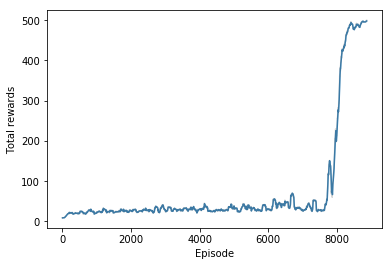

In [25]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

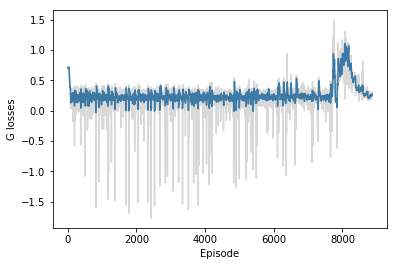

In [26]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

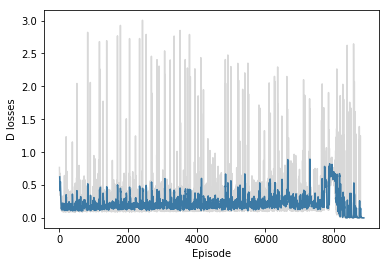

In [27]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [28]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        if total_reward == 500:
            break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model2.ckpt
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.